
# Week 3 - Discovering higher-level Patterns (Topic Modeling & Clustering)

The first 2 weeks have primarily used the word count of documents as their measure, such as counting the number of "positive" and "negative" words to determine sentiment.

This week, we learn a second kind of document representation in clusters or topics. First, we take a text corpus that we have developed and discovery emergent clusters through a process known as clustering or partitioning. We pilot this here both with a well-known *flat* clustering method, `kmeans`, and also a *hierarchical* approach, `Ward's (minimum variance) method`. We will demonstrate a simple (graphical) approach to identifying optimal cluster number, the sillhouette method, and evaluate the quality of unsupervised clusters on labeled data. Next, we will explore a method of two dimensional content clustering called topic modeling (e.g., words cluster in topics; topics cluster in documents). This statistical technique models and computationally induces *topics* from data, which are sparse distributions over (nonexclusive clusters of) words, from which documents can formally be described as sparse mixtures. We will explore these topics and consider their utility for understanding trends within a corpus. We will consider how to construct models that take document cluster and topic loadings as predictive features, the basis of influence metrics and dynamically over time.

For this notebook we will be using the following packages:

In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
!pip install -U git+https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git


#All these packages need to be installed from pip
#These are all for the cluster detection
import sklearn
import sklearn.feature_extraction.text
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.datasets
import sklearn.cluster
import sklearn.decomposition
import sklearn.metrics

import scipy #For hierarchical clustering and some visuals
#import scipy.cluster.hierarchy
import gensim#For topic modeling
import requests #For downloading our datasets
import numpy as np #for arrays
import pandas #gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import matplotlib.cm #Still for graphics
import seaborn as sns #Makes the graphics look nicer

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning, it
%matplotlib inline

import itertools
import json

  Cloning https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git to /tmp/pip-req-build-vi8v3h6v
  Running command git clone --filter=blob:none --quiet https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git /tmp/pip-req-build-vi8v3h6v
  Resolved https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git to commit 9fa6f1abdc19d159d587b4017ee6897fe7a18d4d
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.6/239.6 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.8/117.8 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.8/76.8 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

# Getting our corpora

To begin, we will use a well known corpus of testing documents from the *20 Newsgroups corpus*, a dataset commonly used to illustrate text applications of text clustering and classification. This comes packaged with sklearn and comprises approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 newsgroups. It was originally collected by Ken Lang, probably for his 1995 *Newsweeder: Learning to filter netnews* paper. The data is organized into 20 distinct newsgroups, each corresponding to a different topic. Some of the newsgroups are very closely related (e.g. comp.sys.ibm.pc.hardware / comp.sys.mac.hardware), while others are unrelated (e.g misc.forsale / soc.religion.christian).

In [2]:
newsgroups = sklearn.datasets.fetch_20newsgroups(subset='train', data_home = '../data/scikit_learn_data')
print(dir(newsgroups))

['DESCR', 'data', 'filenames', 'target', 'target_names']


We can ascertain the categories with `target_names` or the actual files with `filenames`

In [3]:
print(newsgroups.target_names)
print(len(newsgroups.data))

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']
11314


We will start by converting the provided data into pandas DataFrames.

First we reduce our dataset for this analysis by dropping some extraneous information and converting it into a DataFrame.

In [4]:
newsgroupsCategories = ['comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos']

newsgroupsDF = pandas.DataFrame(columns = ['text', 'category', 'source_file'])

for category in newsgroupsCategories:
    print("Fetching data for: {}".format(category))
    ng = sklearn.datasets.fetch_20newsgroups(subset='train', categories = [category], remove=['headers', 'footers', 'quotes'], data_home = '../data/scikit_learn_data/')
    newsgroupsDF = newsgroupsDF.append(pandas.DataFrame({'text' : ng.data, 'category' : [category] * len(ng.data), 'source_file' : ng.filenames}), ignore_index=True)

#Creating an explicit index column for later

#newsgroupsDF['index'] = range(len(newsgroupsDF))
#newsgroupsDF.set_index('index', inplace = True)
print(len(newsgroupsDF))
newsgroupsDF[:10]

Fetching data for: comp.sys.mac.hardware
Fetching data for: comp.windows.x
Fetching data for: misc.forsale
Fetching data for: rec.autos
2350


text               category  \
0  \tIn certain Apple 13" RGB monitors there has ...  comp.sys.mac.hardware   
1  Does anyone know how to reach Micron?  I am in...  comp.sys.mac.hardware   
2  Hi there!\n\nCould some kind soul tell me what...  comp.sys.mac.hardware   
3                                        "auto\nfrom  comp.sys.mac.hardware   
4  \n\n    Don't believe the hype. There is no su...  comp.sys.mac.hardware   
5  What is the value of an SE (HDFD) 4/20?\n\n-David  comp.sys.mac.hardware   
6  \n\nF A Q !\n\nReference:\nNewsgroups: comp.sy...  comp.sys.mac.hardware   
7  \n\n\n    Nope. The Apple 16" monitor does not...  comp.sys.mac.hardware   
8  \n\nIs it a hidden option?  I'm using PowerStr...  comp.sys.mac.hardware   
9  \n\n\nThe previous article referred to the fac...  comp.sys.mac.hardware   

                                         source_file  
0  ../data/scikit_learn_data/20news_home/20news-b...  
1  ../data/scikit_learn_data/20news_home/20news-b...  
2  ../data/scikit_learn_data/20news_home/20news-b...  
3  ../data/scikit_learn_data/20news_home/20news-b...  
4  ../data/scikit_learn_data/20news_home/20news-b...  
5  ../data/scikit_learn_data/20news_home/20news-b...  
6  ../data/scikit_learn_data/20news_home/20news-b...  
7  ../data/scikit_learn_data/20news_home/20news-b...  
8  ../data/scikit_learn_data/20news_home/20news-b...  
9  ../data/scikit_learn_data/20news_home/20news-b...

Next, we can convert the documents into word count vectors (e.g., *soc.religion.christian message a* might contain 3 mentions of "church", 2 of "jesus", 1 of "religion", etc., yielding a CountVector=[3,2,1,...])

In [5]:
#First it needs to be initialized
ngCountVectorizer = sklearn.feature_extraction.text.CountVectorizer()
#Then trained
newsgroupsVects = ngCountVectorizer.fit_transform(newsgroupsDF['text'])
print(newsgroupsVects.shape)


(2350, 23525)


I'm pretty sure that you're very familiar with the cell above now, but let's go through the concepts again.

What do we want to do here? We want to do vectorization, i.e., converting texts into numerical features (vectors) as required by machine learning algorithms. And this is what feature_extraction module does: to extract features from texts in a format as required by ML algorithms. feature_extraction module has four classes: CountVectorizer, DictVectorizer, TfidfVectorizer, and FeatureHasher. Here, we use CountVectorizer, but we'll also use TfidfVectorizer as well below.

There are various strategies by which we extract features. Here, we use CountVectorizer, and, in particular, we use 'Bag of Words' representation. In other words, the features we hope to extract from the texts are each individual token occurrence frequency. We simply count the the occurrence of each token in each document. So, here, we get a document-term-matrix, in which documents are characterized by the occurrences of tokens. Other forms of features, such as the relative position information of words, are ignored. We'll see other types of representations and strategies as well soon, such as N-gram (by the way, we can do n-gram with CountVectorizer. CountVectorizer class takes a set of parameters, such as analyzer, which you can specify the n-gram).

the first line of the cell above instantiate a class, CountVectorizer(). In other words, you created an instance, or realization of a class. What is a class and what does instantiation mean? That's a long story, maybe for next time.

This gives us a matrix with row a document and each column a word. The matrix is mostly zeros, so we store it as a sparse matrix, a data structure that contains and indexes only the nonzero entries.

In [6]:
newsgroupsVects

<2350x23525 sparse matrix of type '<class 'numpy.int64'>'
	with 177750 stored elements in Compressed Sparse Row format>

We can use the normal operations on this sparse matrix or convert it to normal matrix (not recommended for large sparse matrices :-)

In [7]:
newsgroupsVects[:10,:20].toarray()

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

What is the toarray() function here? It's similar to todense()--todense() and toarray() both returns a dense representation of a matrix; however, todense() returns a matrix representation while toarray() returns a ndarray representation.

We can also lookup the indices of different words using the Vectorizer

In [8]:
ngCountVectorizer.vocabulary_.get('vector')

21647

There are some more interesting things to do...

Lets start with [term frequency–inverse document frequency](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html)(tf-idf), a method for weighting document-distinguishing words.

In [9]:
#initialize
newsgroupsTFTransformer = sklearn.feature_extraction.text.TfidfTransformer().fit(newsgroupsVects)
#train
newsgroupsTF = newsgroupsTFTransformer.transform(newsgroupsVects)
print(newsgroupsTF.shape)

(2350, 23525)


This gives us the tf-idf for each word in each text

In [10]:
list(zip(ngCountVectorizer.vocabulary_.keys(), newsgroupsTF.data))[:20]

[('in', 0.08265545268171724),
 ('certain', 0.05464092321093494),
 ('apple', 0.19706119834212132),
 ('13', 0.05749878121929968),
 ('rgb', 0.07820822067701588),
 ('monitors', 0.0749569030656185),
 ('there', 0.10567912764152107),
 ('has', 0.1109950967372947),
 ('been', 0.05330795380898169),
 ('problem', 0.21470375597395805),
 ('with', 0.09901319943986409),
 ('the', 0.19389877721110985),
 ('high', 0.1817286448065436),
 ('voltage', 0.19389877721110985),
 ('capasitor', 0.33279218254193177),
 ('knows', 0.18819404816424326),
 ('about', 0.08243502153417578),
 ('this', 0.1619412292430009),
 ('and', 0.13074268623716792),
 ('is', 0.16299450361806797)]

Let's see what we're doing here. First, you need to know what vocabulary\_ does. vocabulary\_ is an attribute of the CountVectorizer, which gives you a mapping of terms to feature indices. It gives you all the terms and their feature indices, so it's a dictionary. So, by doing "ngCountVectorizer.vocabulary\_.keys()", we get the keys of the dictionary, which are the terms.

At first glance, there appears to be a lot of garbage littering this unordered list with unique words and stopwords. Note, however, that words like *apple*, *rgb*, and *voltage* distinguish this newsgroup document, while stopwords post a much lower weight. Note that we could filter out stop words, stem and lem our data before vectorizering, or we can instead use tf-idf to filter our data (or **both**). For exact explanation of all options look [here](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). To prune this matrix of features, we now limit our word vector to 1000 words with at least 3 occurrences, which do not occur in more than half of the documents. There is an extensive science and art to feature engineering for machine learning applications like clustering.

In [11]:
#initialize
ngTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
#train
newsgroupsTFVects = ngTFVectorizer.fit_transform(newsgroupsDF['text'])

Lets look at the matrix

In [12]:
newsgroupsDF['text']

0       \tIn certain Apple 13" RGB monitors there has ...
1       Does anyone know how to reach Micron?  I am in...
2       Hi there!\n\nCould some kind soul tell me what...
3                                             "auto\nfrom
4       \n\n    Don't believe the hype. There is no su...
                              ...                        
2345    I was wondering if anyone out in net-land have...
2346    \n\n\n\n\nI sold my '86 Sprint last April with...
2347    Actually I wasn't too surprised, since I bough...
2348    \n\nI couldnt agree more.  That is how it SHOU...
2349    \nWarren Brown, the Washington Post's auto wri...
Name: text, Length: 2350, dtype: object

In [13]:
newsgroupsDF.shape

(2350, 3)

In [14]:
newsgroupsTFVects[:10, :10].toarray()

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.27150519],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.       

The matrix is much smaller now, only 1000 words, but the same number of documents

We can still look at the words:

In [15]:
try:
    print(ngTFVectorizer.vocabulary_['vector'])
except KeyError:
    print('vector is missing')
    print('The available words are: {} ...'.format(list(ngTFVectorizer.vocabulary_.keys())[:10]))

vector is missing
The available words are: ['certain', 'apple', '13', 'monitors', 'problem', 'high', 'cost', 'bad', 'got', 'local'] ...


In [16]:
try:
    print(ngTFVectorizer.vocabulary_['apple'])
except KeyError:
    print('apple is missing')
    print('The available words are: {} ...'.format(list(ngTFVectorizer.vocabulary_.keys())[:10]))

91


This is a reasonable matrix of features with which to begin identifying clusters.

# Flat Clustering with $K$-means

Lets start with $k$-means, an approach that begins with random clusters of predefined number, then iterates cluster reassignment and evaluates the new clusters relative to an objective function, recursively.

To do this we will need to know how many clusters we are looking for. Here the *true number* of clusters is 4. Of course, in most cases you would not know the number in advance.

In [17]:
numClusters = len(set(newsgroupsDF['category']))
numClusters

4

Then we can initialize our cluster finder

In [18]:
#k-means++ is a better way of finding the starting points
#We could also try providing our own
km = sklearn.cluster.KMeans(n_clusters=numClusters, init='k-means++')

And now we can calculate the clusters

In [19]:
km.fit(newsgroupsTFVects)

KMeans(n_clusters=4)

Once we have the clusters, we can evaluate them with a variety of metrics that sklearn provides. We will look at a few, including *Homogeneity*, *Completeness*, *V-measure* and *Adjusted Rand Score*.

*Homogeneity* is a measure that grows (from 0 to 1) to the degree that all of its clusters contain only data points which are members of a single class (e.g., newsgroup).

*Completeness* is *Homogeneity's* converse: a measure that grows (0 to 1) to the degree that all data points of a given class are also elements of the same cluster.

The *V-measure* is the harmonic mean of *Homogeniety* and *Completeness* ($v = 2 * (homogeneity * completeness) / (homogeneity + completeness$).

the *Adjusted Rand Score* is built atop the *Rand Index (RI)*, which computes the similarity between two clusterings by considering all pairs of samples and counting pairs assigned in the same or different clusters in the predicted and true clusterings (e.g., actual newsgroups). The *RI* is then adjusted for chance as follows:
$ARI = (RI - RI_{expected}) / (max(RI) - RI_{expected})$.
The Adjusted Rand Index is thus ensured to have a value close to 0.0 for random labeling independent of the number of clusters and samples, 1.0 when the clusterings are identical, and -1.0 when they are as bad (i.e., cross-cutting) as they can be.

In [20]:
print("The available metrics are: {}".format([s for s in dir(sklearn.metrics) if s[0] != '_']))
print("For our clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(newsgroupsDF['category'], km.labels_)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(newsgroupsDF['category'], km.labels_)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(newsgroupsDF['category'], km.labels_)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(newsgroupsDF['category'], km.labels_)))

The available metrics are: ['ConfusionMatrixDisplay', 'DetCurveDisplay', 'DistanceMetric', 'PrecisionRecallDisplay', 'PredictionErrorDisplay', 'RocCurveDisplay', 'SCORERS', 'accuracy_score', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'auc', 'average_precision_score', 'balanced_accuracy_score', 'brier_score_loss', 'calinski_harabasz_score', 'check_scoring', 'class_likelihood_ratios', 'classification_report', 'cluster', 'cohen_kappa_score', 'completeness_score', 'confusion_matrix', 'consensus_score', 'coverage_error', 'd2_absolute_error_score', 'd2_pinball_score', 'd2_tweedie_score', 'davies_bouldin_score', 'dcg_score', 'det_curve', 'euclidean_distances', 'explained_variance_score', 'f1_score', 'fbeta_score', 'fowlkes_mallows_score', 'get_scorer', 'get_scorer_names', 'hamming_loss', 'hinge_loss', 'homogeneity_completeness_v_measure', 'homogeneity_score', 'jaccard_score', 'label_ranking_average_precision_score', 'label_ranking_loss', 'log_loss', 'make_scorer', 'matthews_corrcoef

You can evaluate these for different clustering solutions ($1-N$ clusters). You can also interrogate the alignment between specific documents and their cluster assignments by adding the cluster labels to the pandas dataframe.

In [21]:
newsgroupsDF['kmeans_predictions'] = km.labels_
newsgroupsDF

text  \
0     \tIn certain Apple 13" RGB monitors there has ...   
1     Does anyone know how to reach Micron?  I am in...   
2     Hi there!\n\nCould some kind soul tell me what...   
3                                           "auto\nfrom   
4     \n\n    Don't believe the hype. There is no su...   
...                                                 ...   
2345  I was wondering if anyone out in net-land have...   
2346  \n\n\n\n\nI sold my '86 Sprint last April with...   
2347  Actually I wasn't too surprised, since I bough...   
2348  \n\nI couldnt agree more.  That is how it SHOU...   
2349  \nWarren Brown, the Washington Post's auto wri...   

                   category  \
0     comp.sys.mac.hardware   
1     comp.sys.mac.hardware   
2     comp.sys.mac.hardware   
3     comp.sys.mac.hardware   
4     comp.sys.mac.hardware   
...                     ...   
2345              rec.autos   
2346              rec.autos   
2347              rec.autos   
2348              rec.autos   
2349              rec.autos   

                                            source_file  kmeans_predictions  
0     ../data/scikit_learn_data/20news_home/20news-b...                   1  
1     ../data/scikit_learn_data/20news_home/20news-b...                   1  
2     ../data/scikit_learn_data/20news_home/20news-b...                   1  
3     ../data/scikit_learn_data/20news_home/20news-b...                   1  
4     ../data/scikit_learn_data/20news_home/20news-b...                   1  
...                                                 ...                 ...  
2345  ../data/scikit_learn_data/20news_home/20news-b...                   1  
2346  ../data/scikit_learn_data/20news_home/20news-b...                   0  
2347  ../data/scikit_learn_data/20news_home/20news-b...                   0  
2348  ../data/scikit_learn_data/20news_home/20news-b...                   1  
2349  ../data/scikit_learn_data/20news_home/20news-b...                   1  

[2350 rows x 4 columns]

In [22]:
len(set(newsgroupsDF['kmeans_predictions']))

4

We can also look at the distinguishing features in each cluster:

In [23]:
terms = ngTFVectorizer.get_feature_names_out()
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(numClusters):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print('\n')

Top terms per cluster:
Cluster 0:
 car
 cars
 engine
 like
 just
 good
 think
 don
 dealer
 new


Cluster 1:
 mac
 know
 drive
 just
 thanks
 apple
 like
 does
 don
 new


Cluster 2:
 window
 server
 use
 motif
 using
 program
 widget
 application
 code
 windows


Cluster 3:
 sale
 00
 offer
 shipping
 condition
 new
 asking
 interested
 price
 10




Let's construct a visualization of the clusters. First, we will first reduce the
dimensionality of the data using principal components analysis (PCA).

In [24]:
PCA = sklearn.decomposition.PCA
pca = PCA(n_components = 2).fit(newsgroupsTFVects.toarray())
reduced_data = pca.transform(newsgroupsTFVects.toarray())

The cell below is optional. It allows you to do a biplot

In [25]:
components = pca.components_

# Extract cluster centroids
order_centroids = km.cluster_centers_.argsort()[:, ::-1]

keyword_ids = list(set(order_centroids[:,:10].flatten())) #Get the ids of the most distinguishing words(features) from your kmeans model.

terms = ngTFVectorizer.get_feature_names_out()
words = [terms[i] for i in keyword_ids]#Turn the ids into words.
x = components[:,keyword_ids][0,:] #Find the coordinates of those words in your biplot.
y = components[:,keyword_ids][1,:]

Then, let's build a color map for the true labels.

In [26]:
colordict = {
'comp.sys.mac.hardware': 'red',
'comp.windows.x': 'orange',
'misc.forsale': 'green',
'rec.autos': 'blue',
    }
colors = [colordict[c] for c in newsgroupsDF['category']]
print("The categories' colors are:\n{}".format(colordict.items()))

The categories' colors are:
dict_items([('comp.sys.mac.hardware', 'red'), ('comp.windows.x', 'orange'), ('misc.forsale', 'green'), ('rec.autos', 'blue')])


Let's plot the data using the true labels as the colors of our data points.

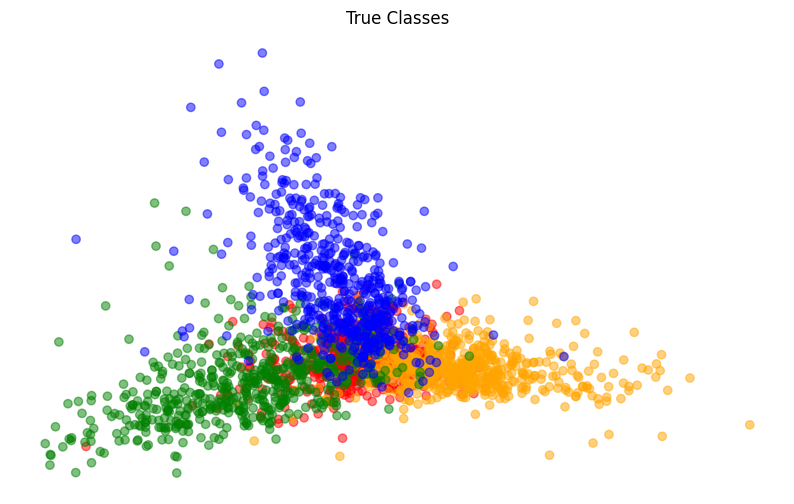

In [27]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.5, label = colors)
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

One nice thing about PCA is that we can also do a biplot and map our feature
vectors to the same space.

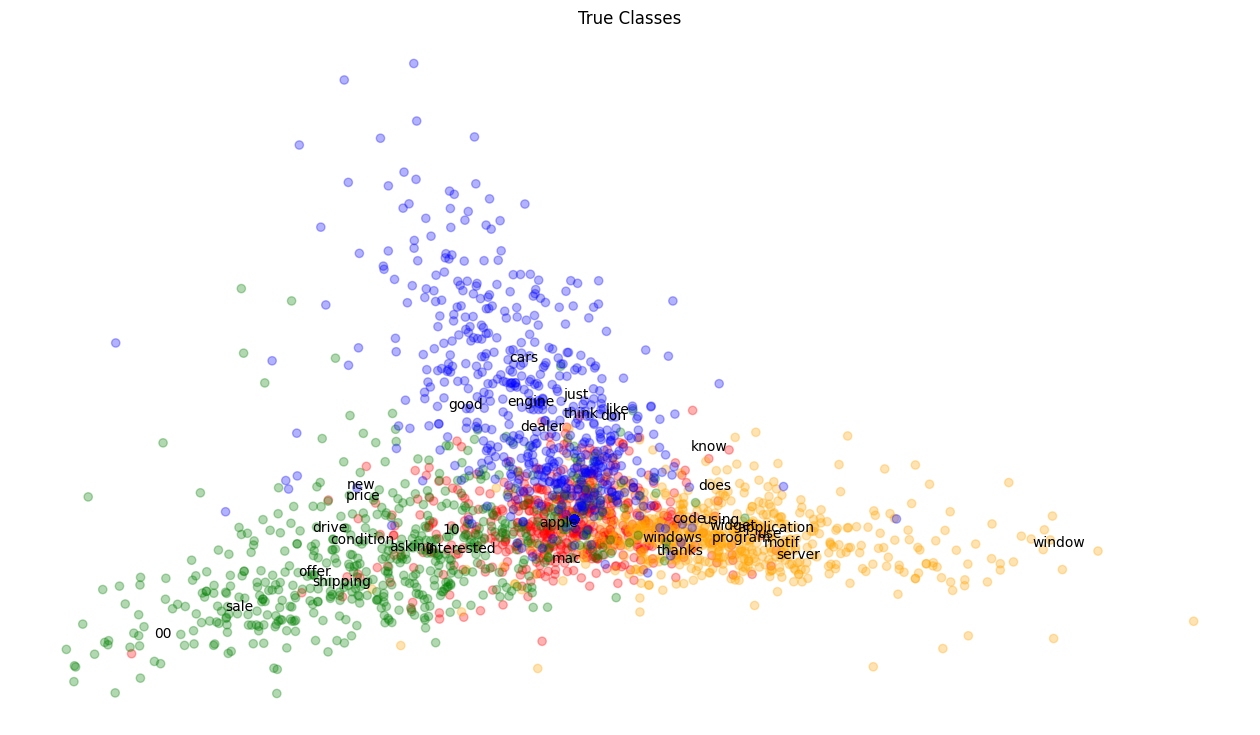

In [28]:
fig = plt.figure(figsize = (16,9))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.3, label = colors)
for i, word in enumerate(words):
    ax.annotate(word, (x[i],y[i]))
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

Let's do it again with predicted clusters.

In [29]:
colors_p = [colordict[newsgroupsCategories[l]] for l in km.labels_]

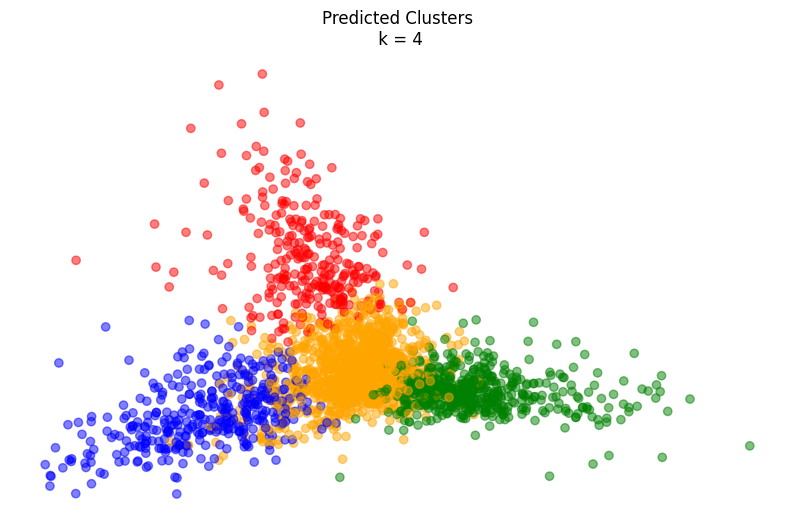

In [30]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = 4')
plt.show()

Let's try with 3 clusters.

In [31]:
km3 = sklearn.cluster.KMeans(n_clusters= 3, init='k-means++')
km3.fit(newsgroupsTFVects.toarray())

KMeans(n_clusters=3)

# Selecting Cluster Number

We can select an optimal cluster number by identifying the lowest of the metrics listed above (e.g., V-measure), but often you don't have "ground truth" or labeled data. For identifying the "best" number of clusters in an unsupervised way, we demonstrate the Silhouette method. Many other methods also exist (e.g., Bayesian Information Criteria or BIC, the visual "elbow criteria", etc.)

First we will define a helper function:

In [32]:
def plotSilhouette(n_clusters, X):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15,5))

    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    clusterer = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10

    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = matplotlib.cm.get_cmap("nipy_spectral")
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    cmap = matplotlib.cm.get_cmap("nipy_spectral")
    colors = cmap(float(i) / n_clusters)
    ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    projected_centers = pca.transform(centers)
    # Draw white circles at cluster centers
    ax2.scatter(projected_centers[:, 0], projected_centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(projected_centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PC 1")
    ax2.set_ylabel("PC 2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()
    print("For n_clusters = {}, The average silhouette_score is : {:.3f}".format(n_clusters, silhouette_avg))

Now we can examine a few different numbers of clusters:

<ipython-input-32-96d9ebbe3b48>:45: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,


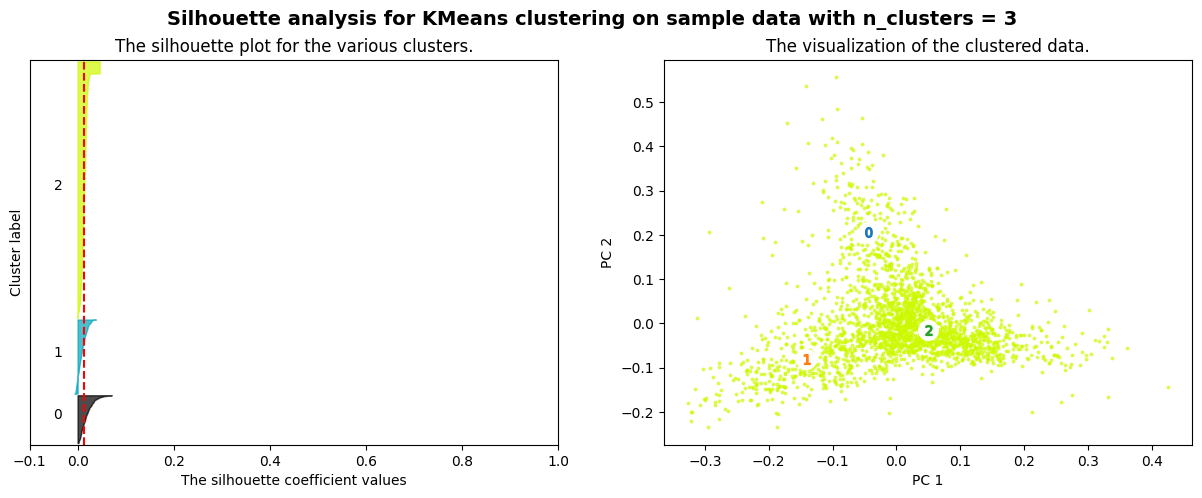

For n_clusters = 3, The average silhouette_score is : 0.014


In [33]:
X = newsgroupsTFVects.toarray()
plotSilhouette(3, X)

<ipython-input-32-96d9ebbe3b48>:45: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,


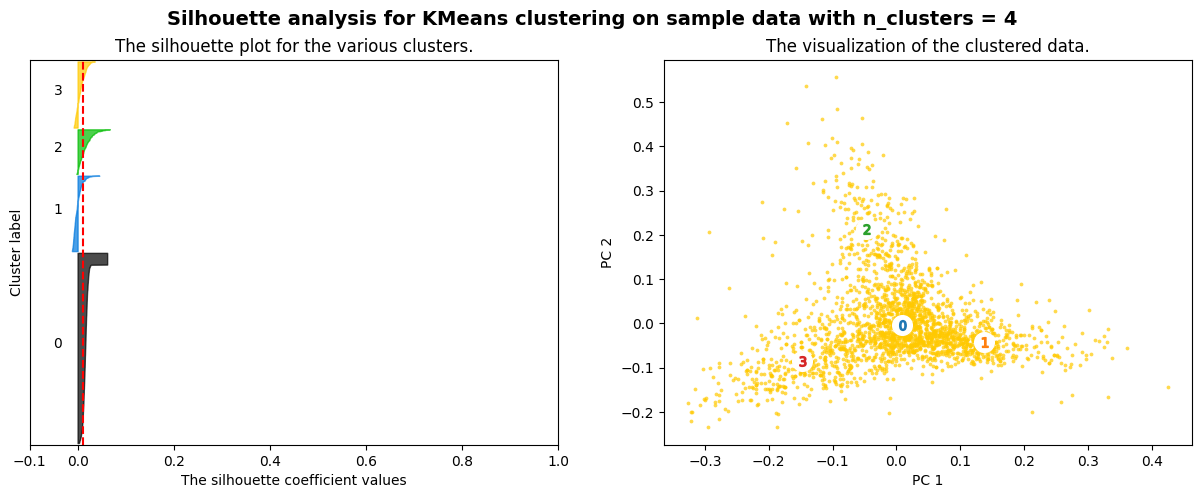

For n_clusters = 4, The average silhouette_score is : 0.012


In [34]:
X = newsgroupsTFVects.toarray()
plotSilhouette(4, X)

<ipython-input-32-96d9ebbe3b48>:45: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,


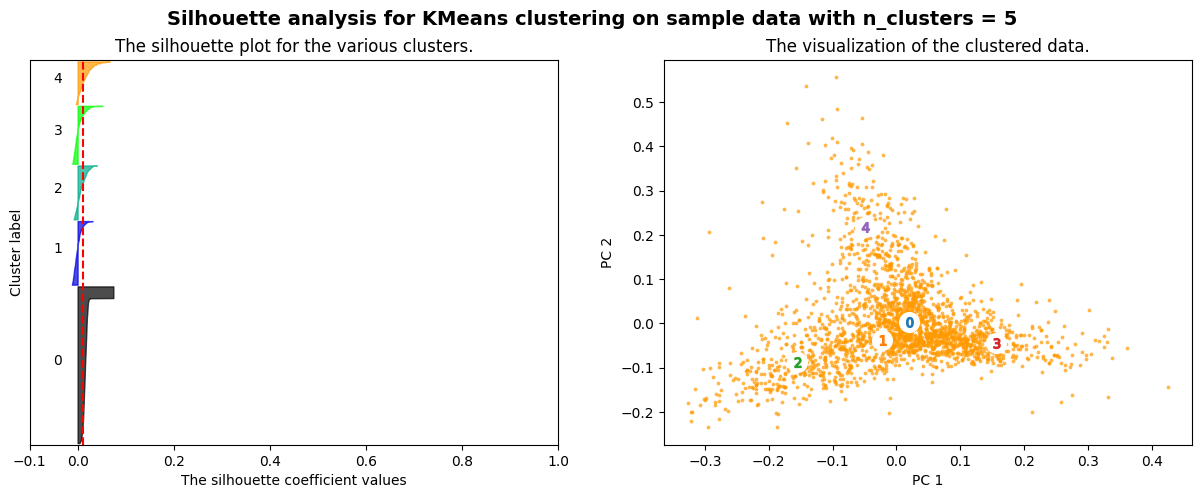

For n_clusters = 5, The average silhouette_score is : 0.011


In [35]:
X = newsgroupsTFVects.toarray()
plotSilhouette(5, X)

<ipython-input-32-96d9ebbe3b48>:45: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,


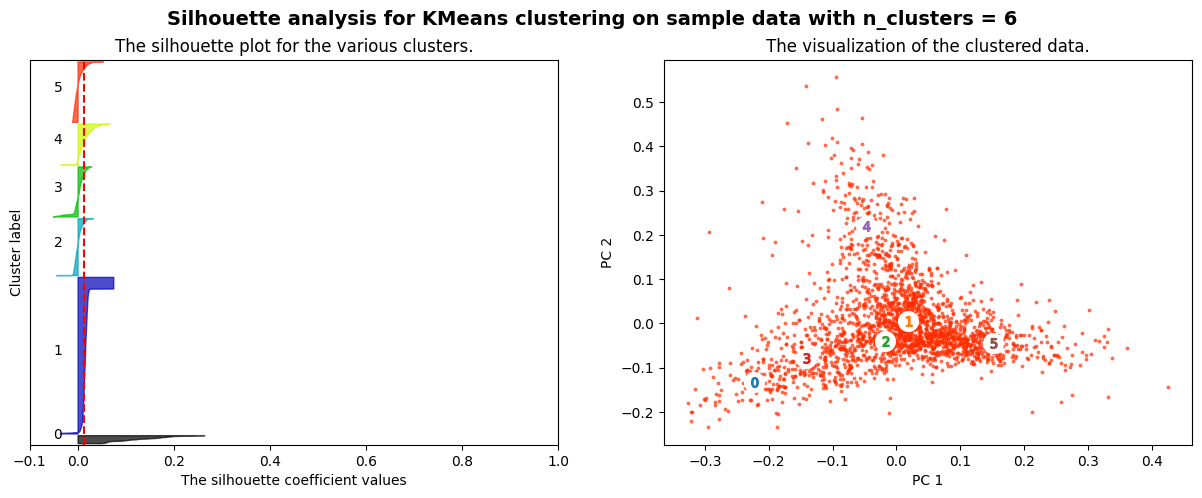

For n_clusters = 6, The average silhouette_score is : 0.013


In [36]:
X = newsgroupsTFVects.toarray()
plotSilhouette(6, X)

Interestingly, the silhouette scores above suggests that 3 is a better number of clusters than 4, which would be accurate if we (reasonsably) grouped the two computer-themed groups.

# Getting new text data

Lets start by using the same function as last lesson and loading a few press releases from 10 different senators into a DataFrame. The code to do this is below, but commented out as we've already downloaded the data to the data directory.

In [38]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [39]:
targetSenator = 'Kennedy'# = ['Voinovich', 'Obama', 'Whitehouse', 'Snowe', 'Rockefeller', 'Murkowski', 'McCain', 'Kyl', 'Baucus', 'Frist']
"""
#Uncomment this to download your own data
senReleasesTraining = pandas.DataFrame()

print("Fetching {}'s data".format(targetSenator))
targetDF = lucem_illud.getGithubFiles('https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/{}'.format(targetSenator), maxFiles = 2000)
targetDF['targetSenator'] = targetSenator
senReleasesTraining = senReleasesTraining.append(targetDF, ignore_index = True)

#Watch out for weird lines when converting to csv
#one of them had to be removed from the Kennedy data so it could be re-read
senReleasesTraining.to_csv("data/senReleasesTraining.csv")
"""

senReleasesTraining = pandas.read_csv("/content/drive/MyDrive/senReleasesTraining.csv")

senReleasesTraining[:5]

Unnamed: 0                                       download_url  \
0           0  https://raw.githubusercontent.com/lintool/Grim...   
1           1  https://raw.githubusercontent.com/lintool/Grim...   
2           2  https://raw.githubusercontent.com/lintool/Grim...   
3           3  https://raw.githubusercontent.com/lintool/Grim...   
4           4  https://raw.githubusercontent.com/lintool/Grim...   

                                            html_url                    name  \
0  https://github.com/lintool/GrimmerSenatePressR...  01Apr2005Kennedy14.txt   
1  https://github.com/lintool/GrimmerSenatePressR...  01Aug2005Kennedy12.txt   
2  https://github.com/lintool/GrimmerSenatePressR...  01Aug2006Kennedy10.txt   
3  https://github.com/lintool/GrimmerSenatePressR...  01Aug2006Kennedy11.txt   
4  https://github.com/lintool/GrimmerSenatePressR...  01Aug2006Kennedy12.txt   

                                 path  \
0  raw/Kennedy/01Apr2005Kennedy14.txt   
1  raw/Kennedy/01Aug2005Kennedy12.txt   
2  raw/Kennedy/01Aug2006Kennedy10.txt   
3  raw/Kennedy/01Aug2006Kennedy11.txt   
4  raw/Kennedy/01Aug2006Kennedy12.txt   

                                                text targetSenator  
0           FOR IMMEDIATE RELEASE   FOR IMMEDIATE...       Kennedy  
1           FOR IMMEDIATE RELEASE   FOR IMMEDIATE...       Kennedy  
2           FOR IMMEDIATE RELEASE  FOR IMMEDIATE ...       Kennedy  
3           FOR IMMEDIATE RELEASE  FOR IMMEDIATE ...       Kennedy  
4           FOR IMMEDIATE RELEASE  FOR IMMEDIATE ...       Kennedy

Now we have the files we can tokenize and normalize.

The normalized text is good, but we know that the texts will have a large amount of overlap so we can use tf-idf to remove some of the most frequent words. Before doing that, there is one empty cell, let's remove that.

In [40]:
senReleasesTraining = senReleasesTraining.dropna(axis=0, how='any')

In [41]:
#Similar parameters to before, but stricter max df and no max num occurrences
senTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
senTFVects = senTFVectorizer.fit_transform(senReleasesTraining['text'])
senTFVectorizer.vocabulary_.get('senat', 'Missing "Senate"')

'Missing "Senate"'

# Clustering with our new data

One nice thing about using DataFrames for everything is that we can quickly convert code from one input to another. Below we are redoing the cluster detection with our senate data. If you setup your DataFrame the same way it should be able to run on this code, without much work.

First we will define what we will be working with

In [42]:
targetDF = senReleasesTraining
textColumn = 'text'
numCategories = 3

Tf-IDf vectorizing

In [43]:
exampleTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
#train
exampleTFVects = ngTFVectorizer.fit_transform(targetDF[textColumn])

Running k means

In [44]:
exampleKM = sklearn.cluster.KMeans(n_clusters = numCategories, init='k-means++')
exampleKM.fit(exampleTFVects)

KMeans(n_clusters=3)

And visualize:

In [45]:
examplePCA = sklearn.decomposition.PCA(n_components = 2).fit(exampleTFVects.toarray())
reducedPCA_data = examplePCA.transform(exampleTFVects.toarray())

colors = list(plt.cm.rainbow(np.linspace(0,1, numCategories)))
colors_p = [colors[l] for l in exampleKM.labels_]

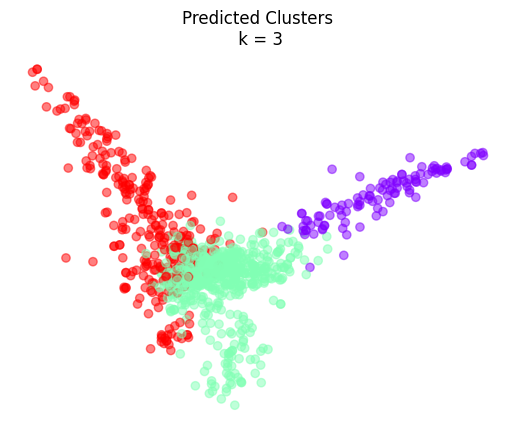

In [46]:
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reducedPCA_data[:, 0], reducedPCA_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = {}'.format(numCategories))
plt.show()

In this case, there may be two clusters that could be identified with Silhouette analysis or some of the metrics described above; although not having true classes makes that tricky. Below, we add these cluster assignments to the dataframe for individual perusal and evaluation.

In [47]:
targetDF['kmeans_predictions'] = exampleKM.labels_
targetDF

Unnamed: 0                                       download_url  \
0             0  https://raw.githubusercontent.com/lintool/Grim...   
1             1  https://raw.githubusercontent.com/lintool/Grim...   
2             2  https://raw.githubusercontent.com/lintool/Grim...   
3             3  https://raw.githubusercontent.com/lintool/Grim...   
4             4  https://raw.githubusercontent.com/lintool/Grim...   
..          ...                                                ...   
994         995  https://raw.githubusercontent.com/lintool/Grim...   
995         996  https://raw.githubusercontent.com/lintool/Grim...   
996         997  https://raw.githubusercontent.com/lintool/Grim...   
997         998  https://raw.githubusercontent.com/lintool/Grim...   
998         999  https://raw.githubusercontent.com/lintool/Grim...   

                                              html_url  \
0    https://github.com/lintool/GrimmerSenatePressR...   
1    https://github.com/lintool/GrimmerSenatePressR...   
2    https://github.com/lintool/GrimmerSenatePressR...   
3    https://github.com/lintool/GrimmerSenatePressR...   
4    https://github.com/lintool/GrimmerSenatePressR...   
..                                                 ...   
994  https://github.com/lintool/GrimmerSenatePressR...   
995  https://github.com/lintool/GrimmerSenatePressR...   
996  https://github.com/lintool/GrimmerSenatePressR...   
997  https://github.com/lintool/GrimmerSenatePressR...   
998  https://github.com/lintool/GrimmerSenatePressR...   

                       name                                path  \
0    01Apr2005Kennedy14.txt  raw/Kennedy/01Apr2005Kennedy14.txt   
1    01Aug2005Kennedy12.txt  raw/Kennedy/01Aug2005Kennedy12.txt   
2    01Aug2006Kennedy10.txt  raw/Kennedy/01Aug2006Kennedy10.txt   
3    01Aug2006Kennedy11.txt  raw/Kennedy/01Aug2006Kennedy11.txt   
4    01Aug2006Kennedy12.txt  raw/Kennedy/01Aug2006Kennedy12.txt   
..                      ...                                 ...   
994  18Jul2005Kennedy13.txt  raw/Kennedy/18Jul2005Kennedy13.txt   
995  18Jul2005Kennedy14.txt  raw/Kennedy/18Jul2005Kennedy14.txt   
996   18Jul2006Kennedy0.txt   raw/Kennedy/18Jul2006Kennedy0.txt   
997   18Jul2006Kennedy1.txt   raw/Kennedy/18Jul2006Kennedy1.txt   
998   18Jul2006Kennedy2.txt   raw/Kennedy/18Jul2006Kennedy2.txt   

                                                  text targetSenator  \
0             FOR IMMEDIATE RELEASE   FOR IMMEDIATE...       Kennedy   
1             FOR IMMEDIATE RELEASE   FOR IMMEDIATE...       Kennedy   
2             FOR IMMEDIATE RELEASE  FOR IMMEDIATE ...       Kennedy   
3             FOR IMMEDIATE RELEASE  FOR IMMEDIATE ...       Kennedy   
4             FOR IMMEDIATE RELEASE  FOR IMMEDIATE ...       Kennedy   
..                                                 ...           ...   
994           FOR IMMEDIATE RELEASE     Department ...       Kennedy   
995           FOR IMMEDIATE RELEASE     I welcome t...       Kennedy   
996           FOR IMMEDIATE RELEASE  FOR IMMEDIATE ...       Kennedy   
997           FOR IMMEDIATE RELEASE  FOR IMMEDIATE ...       Kennedy   
998           FOR IMMEDIATE RELEASE  FOR IMMEDIATE ...       Kennedy   

     kmeans_predictions  
0                     2  
1                     1  
2                     2  
3                     1  
4                     1  
..                  ...  
994                   2  
995                   1  
996                   1  
997                   1  
998                   1  

[999 rows x 8 columns]

## <font color="red">*Exercise 1*</font>

<font color="red">Construct cells immediately below this that construct features and cluster your documents using K-means and a variety of cluster numbers. Interrogate the cluster contents in terms of both documents and features. Identify the "optimal" cluster number with Silhouette analysis. Plot clusters and features after reducing with PCA. What does this cluster structure reveal about the organization of documents in your corpora?

In [48]:
# import wia
wia = pandas.read_excel("/content/drive/MyDrive/DBCommunity/2024-1-13-13-35-21-303165551212861-Women in Academia 女性在学术界小组-采集的数据-后羿采集器.xlsx")
wia = wia[["讨论", "字段1", "作者", "回应", "最后回应", "发布时间", "字段2", "字段3", "字段4"]]
wia = wia.rename(columns={"讨论":"Title", "字段1":"Text", "作者":"Author", "最后回应":"LastReply", "发布时间":"PublishTime", "回应":"Reply", "字段2":"Like", "字段3":"Collect", "字段4":"Repost"})
wia.dropna(subset=['Text'], inplace=True)
wia[:5]

Title  \
1  精华\n\n\n                    \n                ...   
2  精华\n\n\n                    \n                ...   
3  精华\n\n\n                    \n                ...   
4  精华\n\n\n                    \n                ...   
5  精华\n\n\n                    \n                ...   

                                                Text   Author Reply  \
1  由猴面包树组员倡议，我们小组建立官方slack交流群啦！为了营造一个更友好安全的交流氛围，目...  Anon加重音  1115   
2  —————————本帖为问卷调查、招募研究对象的集中贴，姐妹们如有问卷调查需要大家帮忙填写或...  Anon加重音    64   
3  前情(意见征集贴) https://www.douban.com/group/topic/1...  Anon加重音    12   
4  论坛第二期分享会她说PhD：不同的人生路径的文字稿和音频分享来啦。非常感谢小组长们的全力支持...   Sophie     2   
5  09/30/21更新: 管理员实在是没有能力及时追踪所有申请相关的帖子，大家有相关的帖子想要...       丸子     6   

    LastReply          PublishTime   Like  Collect  Repost  
1  2023-12-21  2020-10-09 08:25:49  270.0    413.0    44.0  
2  2023-12-01  2020-10-14 12:38:45   12.0     28.0     1.0  
3  2023-07-04  2020-10-10 22:01:03   49.0     64.0     4.0  
4  2023-05-03  2020-11-02 04:35:37   13.0      6.0     NaN  
5  2023-03-25  2020-12-09 03:43:55   27.0    293.0    15.0

In [49]:
import jieba

In [50]:
wia['Text'][1]

'由猴面包树组员倡议，我们小组建立官方slack交流群啦！为了营造一个更友好安全的交流氛围，目前加入小组slack群by invitation only，进群方式详见后文。slack目前没有地区限制，有分channel、自定义emoji、智能bot等丰富的功能，slack新手可以看这个官方slack官方指南目前设置的channel包括：#general 主channel#random 日常闲聊划水，逃避工作虽可耻但却快乐！#social-sciences 社会科学姐妹聚集地#humanities 人文艺术姐妹聚集地#engineering 工程姐妹聚集地#natural-sciences 自然科学姐妹聚集地#business 商科姐妹聚集地#prospective-phd-students 2021fall phd申请姐妹交流群#professorship 青教/AP/教职专区如果其他channel需求，可私信我开通～进群后会默认加入#general和#random，想加入其他channel可以在左边栏点击Channels旁边的加号➕，然后点击browse channels就可以看到群里所有的public channels啦然后按需加入～进群申请方式：回复本贴后立刻截图(截图里应该会包括自己刚刚的回复和本帖标题)，将截图豆油发给@猴面包树或@华丽丽的乌卒卒@个个子，同时简单阐述一下进群理由。管理员审核通过后，将会给你发送入群邀请链接～(slack群友可以邀请自己认识的不使用豆瓣的姐妹们，但需在slack上私聊 @猴面包树或@华丽丽的乌卒卒@个个子 转达被邀请者的入组理由，方可成功邀请)'

In [51]:
print(" ".join(jieba.cut(wia['Text'][1], HMM=False)))

Building prefix dict from the default dictionary ...
DEBUG:jieba:Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
DEBUG:jieba:Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.975 seconds.
DEBUG:jieba:Loading model cost 0.975 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.


由 猴面包树 组员 倡议 ， 我们 小组 建立 官方 slack 交流 群 啦 ！ 为了 营造 一个 更 友好 安全 的 交流 氛围 ， 目前 加入 小组 slack 群 by   invitation   only ， 进 群 方式 详见 后 文 。 slack 目前 没有 地区 限制 ， 有 分 channel 、 自定义 emoji 、 智能 bot 等 丰富 的 功能 ， slack 新手 可以 看 这个 官方 slack 官方 指南 目前 设置 的 channel 包括 ： # general   主 channel # random   日常 闲聊 划水 ， 逃避 工作 虽 可耻 但 却 快乐 ！ # social - sciences   社会科学 姐妹 聚集地 # humanities   人文 艺术 姐妹 聚集地 # engineering   工程 姐妹 聚集地 # natural - sciences   自然科学 姐妹 聚集地 # business   商科 姐妹 聚集地 # prospective - phd - students   2021fall   phd 申请 姐妹 交流 群 # professorship   青 教 / AP / 教职 专区 如果 其他 channel 需求 ， 可 私信 我 开通 ～ 进 群 后 会 默认 加入 # general 和 # random ， 想 加入 其他 channel 可以 在 左边 栏 点击 Channels 旁边 的 加号 ➕ ， 然后 点击 browse   channels 就 可以 看到 群 里 所有 的 public   channels 啦 然后 按 需 加入 ～ 进 群 申请 方式 ： 回复 本 贴 后 立刻 截图 ( 截图 里 应该 会 包括 自己 刚刚 的 回复 和 本帖 标题 ) ， 将 截图 豆油 发给 @ 猴面包树 或 @ 华丽 丽 的 乌 卒 卒 @ 个 个子 ， 同时 简单 阐述 一下 进 群 理由 。 管理员 审核 通过 后 ， 将 会 给 你 发送 入 群 邀请 链接 ～ ( slack 群友 可以 邀请 自己 认识 的 不 使用 豆瓣 的 姐妹 们 ， 但 需 在 slack 上 私聊   @ 猴面包树 或 @ 华丽 丽 的 乌 卒 卒 @ 个 个子  

In [52]:
# Segment the text (Chinese text has no spaces)
wia["seg_text"] = wia['Text'].apply(lambda x: " ".join(jieba.cut(x, HMM=False)))

In [53]:
wia[:5]

Title  \
1  精华\n\n\n                    \n                ...   
2  精华\n\n\n                    \n                ...   
3  精华\n\n\n                    \n                ...   
4  精华\n\n\n                    \n                ...   
5  精华\n\n\n                    \n                ...   

                                                Text   Author Reply  \
1  由猴面包树组员倡议，我们小组建立官方slack交流群啦！为了营造一个更友好安全的交流氛围，目...  Anon加重音  1115   
2  —————————本帖为问卷调查、招募研究对象的集中贴，姐妹们如有问卷调查需要大家帮忙填写或...  Anon加重音    64   
3  前情(意见征集贴) https://www.douban.com/group/topic/1...  Anon加重音    12   
4  论坛第二期分享会她说PhD：不同的人生路径的文字稿和音频分享来啦。非常感谢小组长们的全力支持...   Sophie     2   
5  09/30/21更新: 管理员实在是没有能力及时追踪所有申请相关的帖子，大家有相关的帖子想要...       丸子     6   

    LastReply          PublishTime   Like  Collect  Repost  \
1  2023-12-21  2020-10-09 08:25:49  270.0    413.0    44.0   
2  2023-12-01  2020-10-14 12:38:45   12.0     28.0     1.0   
3  2023-07-04  2020-10-10 22:01:03   49.0     64.0     4.0   
4  2023-05-03  2020-11-02 04:35:37   13.0      6.0     NaN   
5  2023-03-25  2020-12-09 03:43:55   27.0    293.0    15.0   

                                            seg_text  
1  由 猴面包树 组员 倡议 ， 我们 小组 建立 官方 slack 交流 群 啦 ！ 为了 营...  
2  — — — — — — — — — 本帖 为 问卷调查 、 招募 研究 对象 的 集中 贴 ...  
3  前 情 ( 意见 征集 贴 )   https : / / www . douban . c...  
4  论坛 第二期 分享 会 她 说 PhD ： 不同 的 人生 路径 的 文字 稿 和 音频 分...  
5  09 / 30 / 21 更新 :   管理员 实在 是 没有 能力 及时 追踪 所有 申请...

In [55]:
# import Chinese stopwords
with open("/content/drive/MyDrive/DBCommunity/my_stopwords.txt") as file:
    cn_stopwords = [line.rstrip() for line in file]

cn_stopwords[:10]

['里', '是', '有', '想', '很', '出', '做', '不', '日', '月']

In [56]:
# Vectorize the segmented text
wiaVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words=cn_stopwords, norm='l2')
#train
wiaVects = wiaVectorizer.fit_transform(wia['seg_text'])

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ain', 'aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'll', 'mon', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


In [57]:
# look at the items in the vectors
try:
    print(wiaVectorizer.vocabulary_['phd'])
except KeyError:
    print('phd')
    print('The available words are: {} ...'.format(list(wiaVectorizer.vocabulary_.keys())[:10]))


77


So the word "phd" has occurred in the corpus for 77 times.

In [58]:
# give the tf-idf for each word in each text
wiaTFTransformer = sklearn.feature_extraction.text.TfidfTransformer().fit(wiaVects)
# train
wiaTF = wiaTFTransformer.transform(wiaVects)
print(wiaTF.shape)

(5254, 1000)


In [59]:
list(zip(wiaVectorizer.vocabulary_.keys(), wiaTF.data))[:20]

[('小组', 0.20466514412733686),
 ('建立', 0.14824840851131366),
 ('交流', 0.212177128387202),
 ('氛围', 0.12537726631445595),
 ('方式', 0.20376609429416398),
 ('地区', 0.13493867451232383),
 ('功能', 0.1947648684731169),
 ('设置', 0.1508722902695551),
 ('包括', 0.18311276157620393),
 ('日常', 0.16049798322916217),
 ('工作', 0.03960074204372201),
 ('快乐', 0.15810865364487472),
 ('social', 0.1369133664610185),
 ('姐妹', 0.2202237050338511),
 ('人文', 0.09550837798978984),
 ('艺术', 0.17338077582090525),
 ('工程', 0.17338077582090525),
 ('商科', 0.1384510752951972),
 ('phd', 0.07471152229739032),
 ('申请', 0.05351375808707389)]

**Cluster the document with K-means**

In [60]:
km = sklearn.cluster.KMeans(n_clusters=4, init='k-means++')
km.fit(wiaVects)

KMeans(n_clusters=4)

In [61]:
wia['km_predic_4'] = km.labels_
wia[10:20]

Title  \
11  急急国王提问：25fall无paper应该继续all in申博还是速度找实习   
12             本人研三 民族学 想申请人类学PhD 求助各位友友‼️   
13       和同学组队中了ica单数由于对方想要所有赞助和报销，希望我不...   
14                                要不要继续搞科研   
15                           Lingvist拼团五缺一   
16                     陆本来加拿大读研，就读体验上升两个台阶   
17                           求助🎩申请视频剪辑专业指导   
18                              是否应该转硕出国呢？   
19                               Mplus相关问题   
20                   如何对自己学术能力进行较为准确地定位和认知   

                                                 Text   Author Reply  \
11  1️⃣ 个人背景本人本科双非，竞赛保研211理工科，目前无发表基本上无项目经验。一直想读博，...    加州龙须面    12   
12  本人硕士就读于一所民族211，专业是少数民族经济，属于民族学，是民族学与经济学的交叉学科。硕...     momo     9   
13  新问题：考虑到现在已经彻底闹翻了（她说自己没钱想要所有的funding和报销，其实一直吵的也...     momo     6   
14  我，本科985院校保研到国内TOP5高校直博（相当于硕博连读），目前在某省内TOP5高校(非...   进化中的皮蛋    20   
15  蹲一个iOS端姐妹一起拼Lingvist家庭版会员！每个人只需要88块就可以一整年会员啦，语...    陪小狗遛弯   NaN   
16  两个导师，一个五十岁一个六十岁，依然在科研一线亲自写文章写书带学生。每周和我二对一meeti...   埋头驱赶空荡   NaN   
17  关于科研项目或🎩申请的视频录音剪辑，友友们有没有觉得还不错的公司或专业人士（曾经帮助自己或老...  Hoodman   NaN   
18  最近实在太纠结，太苦恼，所以想听听大家如果处于这种情况会如何选择。lz目前直博二年级，人文社...    用户已睡觉     4   
19  有没有用mplus跑潜变量增长混合模型的姐妹，模型拟合不好，模型拟合最终结果χ2=57.55...  Maruko🌻     1   
20  各位前辈好，我是一名社科类研一硕士，近期有一些因参加年会/论坛而产生的疑惑，想向各位前辈寻求...   寡王一路硕博    17   

      LastReply          PublishTime  Like  Collect  Repost  \
11  01-13 14:31  2024-01-11 15:15:08   4.0      NaN     1.0   
12  01-13 14:18  2023-12-27 16:22:49   7.0     11.0     NaN   
13  01-13 14:18  2024-01-11 21:09:06   NaN      NaN     NaN   
14  01-12 19:09  2024-01-08 20:29:19  13.0      9.0     2.0   
15  01-12 16:57  2024-01-12 16:57:19   NaN      NaN     NaN   
16  01-12 14:16  2024-01-12 14:16:18   2.0      1.0     NaN   
17  01-12 13:06  2024-01-12 13:06:02   NaN      NaN     NaN   
18  01-12 10:04  2024-01-10 01:52:58   1.0      2.0     NaN   
19  01-12 08:49  2024-01-11 21:18:34   NaN      NaN     NaN   
20  01-11 19:55  2023-12-29 15:35:33  37.0     58.0     6.0   

                                             seg_text  km_predic_4  
11  1 ️ ⃣   个人 背景 本人 本科 双 非 ， 竞赛 保 研 211 理工科 ， 目前 ...            2  
12  本人 硕士 就读于 一所 民族 211 ， 专业 是 少数民族 经济 ， 属于 民族学 ， ...            2  
13  新 问题 ： 考虑 到 现在 已经 彻底 闹翻 了 （ 她 说 自己 没 钱 想要 所有 的...            3  
14  我 ， 本科 985 院校 保 研 到 国内 TOP5 高校 直 博 （ 相当于 硕 博 连...            2  
15  蹲 一个 iOS 端 姐妹 一起 拼 Lingvist 家庭版 会员 ！ 每个 人 只 需要...            3  
16  两个 导师 ， 一个五十岁 一个六十岁 ， 依然 在 科研 一线 亲自 写文章 写 书 带 ...            1  
17  关于 科研项目 或 🎩 申请 的 视频 录音 剪辑 ， 友友 们 有没有 觉得 还 不错 的...            3  
18  最近 实在 太 纠结 ， 太 苦恼 ， 所以 想 听听 大家 如果 处于 这种 情况 会 如...            2  
19  有没有 用 mplus 跑 潜 变量 增长 混合 模型 的 姐妹 ， 模型 拟合 不好 ， ...            3  
20  各位 前辈 好 ， 我 是 一名 社科类 研 一 硕士 ， 近期 有 一些 因 参加 年 会...            3

In [62]:
# look at the distinguishing features in each cluster
terms = wiaVectorizer.get_feature_names_out()
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(4):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print('\n')

Top terms per cluster:
Cluster 0:
 申请
 phd
 学校
 教授
 项目
 offer
 面试
 姐妹
 硕士
 博士


Cluster 1:
 老师
 导师
 邮件
 回复
 面试
 研究
 学校
 方向
 申请
 学生


Cluster 2:
 专业
 方向
 工作
 研究
 博士
 国内
 毕业
 硕士
 本科
 学校


Cluster 3:
 姐妹
 论文
 谢谢
 有没有
 感觉
 真的
 研究
 分享
 学习
 女性




Summarize the essence of each cluster:
0. Socialize with the members within the group "Women in Academia"
1. Publication
2. Future plan
3. Master/Ph.D. program application

Intuitively, the clusters 3 and 4 should be combined. Let's visualize it and see if our intuition is right!

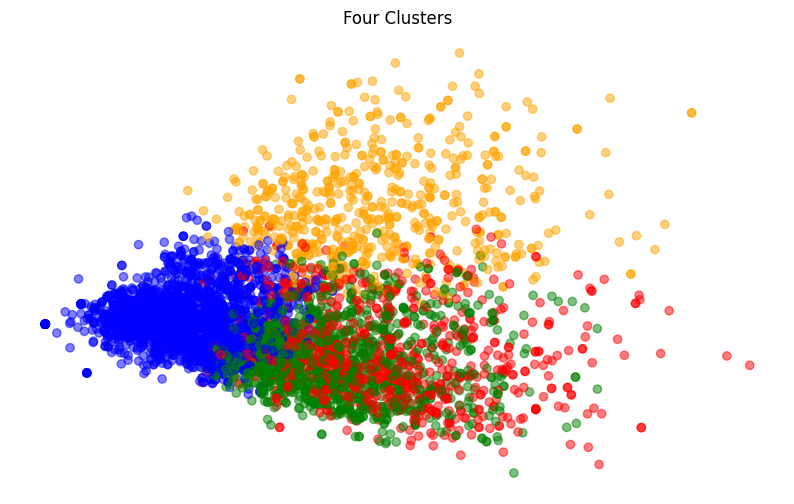

In [63]:
# visualization
PCA = sklearn.decomposition.PCA
pca = PCA(n_components=2).fit(wiaVects.toarray())
reduced_data = pca.transform(wiaVects.toarray())

components = pca.components_
keyword_ids = list(set(order_centroids[:,:10].flatten()))
words = [terms[i] for i in keyword_ids]
x = components[:,keyword_ids][0,:]
y = components[:,keyword_ids][1,:]

colordict = {
'0': 'red',
'1': 'orange',
'2': 'green',
'3': 'blue',
    }
colors = [colordict[str(c)] for c in wia['km_predic_4']]

fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.5, label = colors)
plt.xticks(())
plt.yticks(())
plt.title('Four Clusters')
plt.show()

From the scatter plot, we can see clusters 1 and 3 are overlapping. Probably, the optimal cluster number is 3. Let's see it in the next steps.

**Selecting Cluster Number**

<ipython-input-32-96d9ebbe3b48>:45: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,


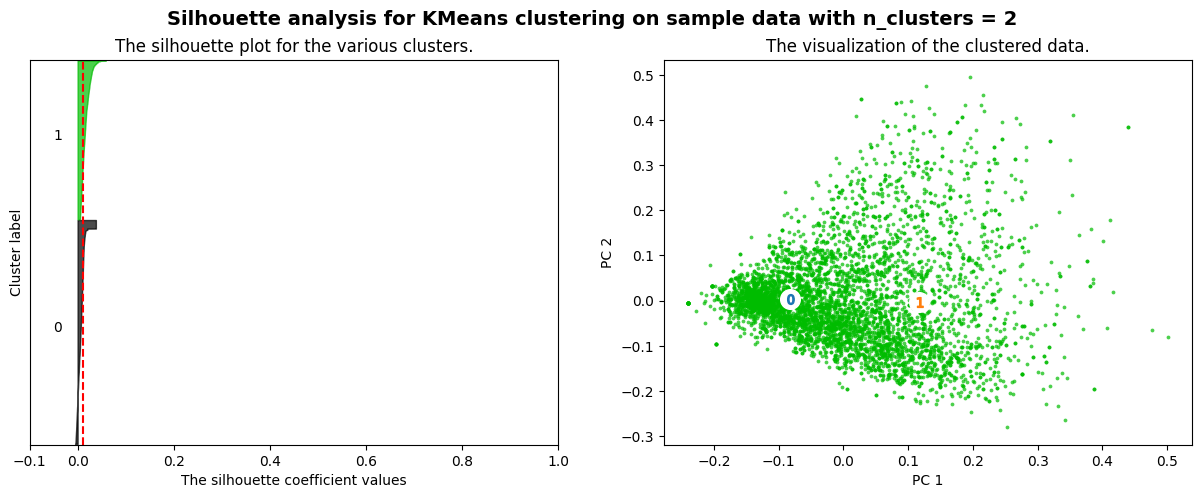

For n_clusters = 2, The average silhouette_score is : 0.011


In [64]:
X = wiaVects.toarray()
plotSilhouette(2, X)

<ipython-input-32-96d9ebbe3b48>:45: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,


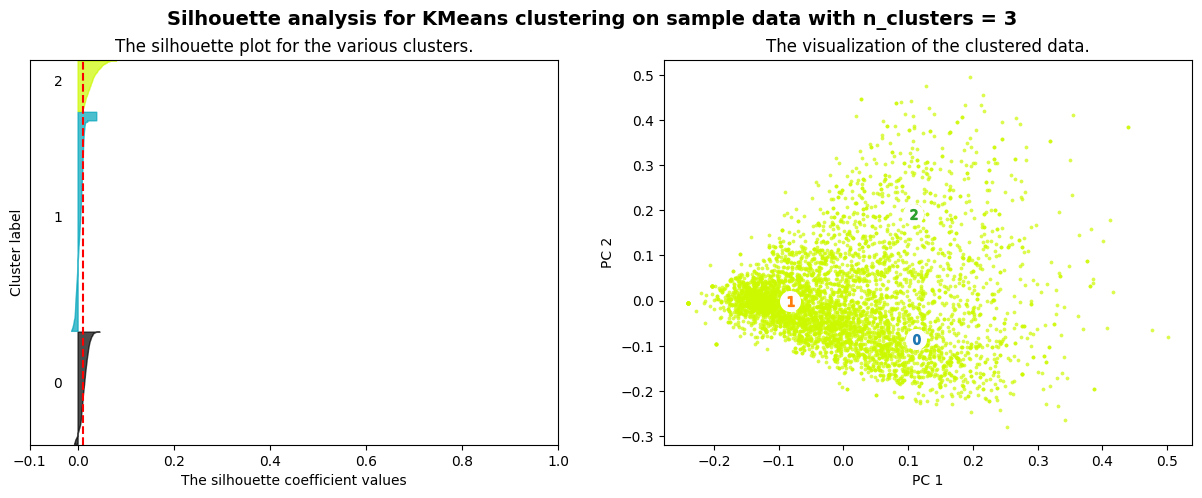

For n_clusters = 3, The average silhouette_score is : 0.011


In [65]:
X = wiaVects.toarray()
plotSilhouette(3, X)

<ipython-input-32-96d9ebbe3b48>:45: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,


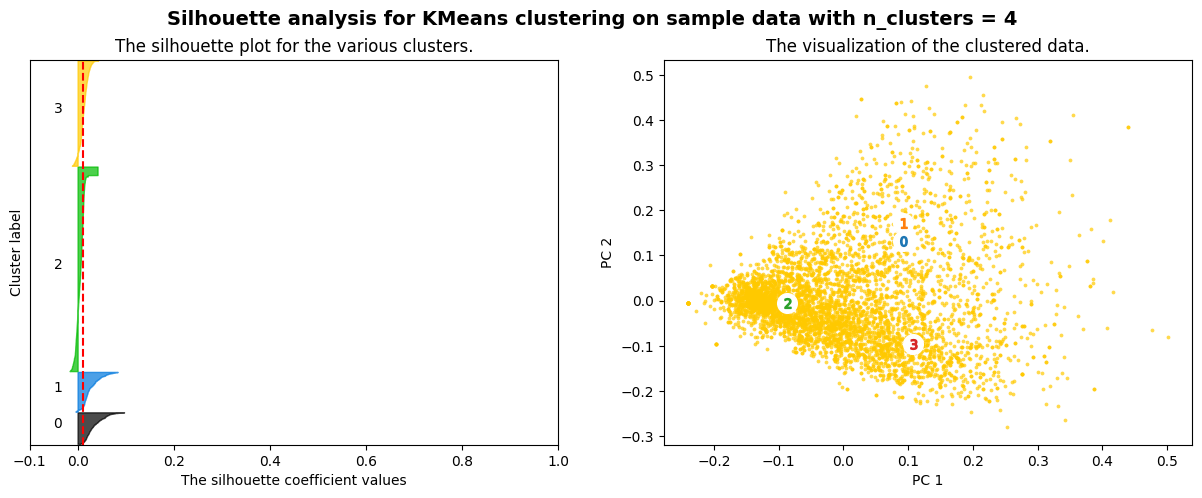

For n_clusters = 4, The average silhouette_score is : 0.012


In [66]:
X = wiaVects.toarray()
plotSilhouette(4, X)

<ipython-input-32-96d9ebbe3b48>:45: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,


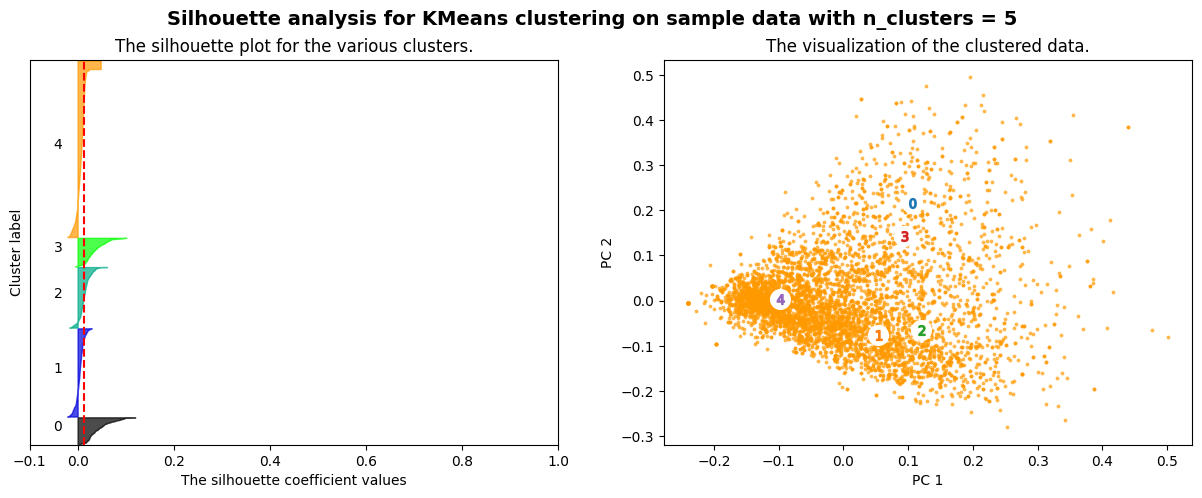

For n_clusters = 5, The average silhouette_score is : 0.013


In [67]:
X = wiaVects.toarray()
plotSilhouette(5, X)

<ipython-input-32-96d9ebbe3b48>:45: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,


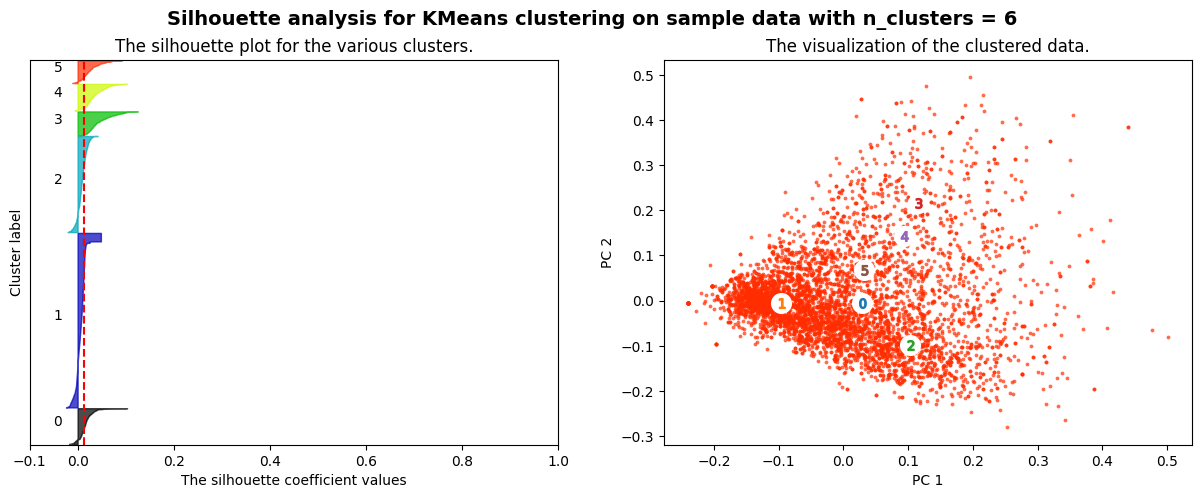

For n_clusters = 6, The average silhouette_score is : 0.014


In [68]:
X = wiaVects.toarray()
plotSilhouette(6, X)

<ipython-input-32-96d9ebbe3b48>:45: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,


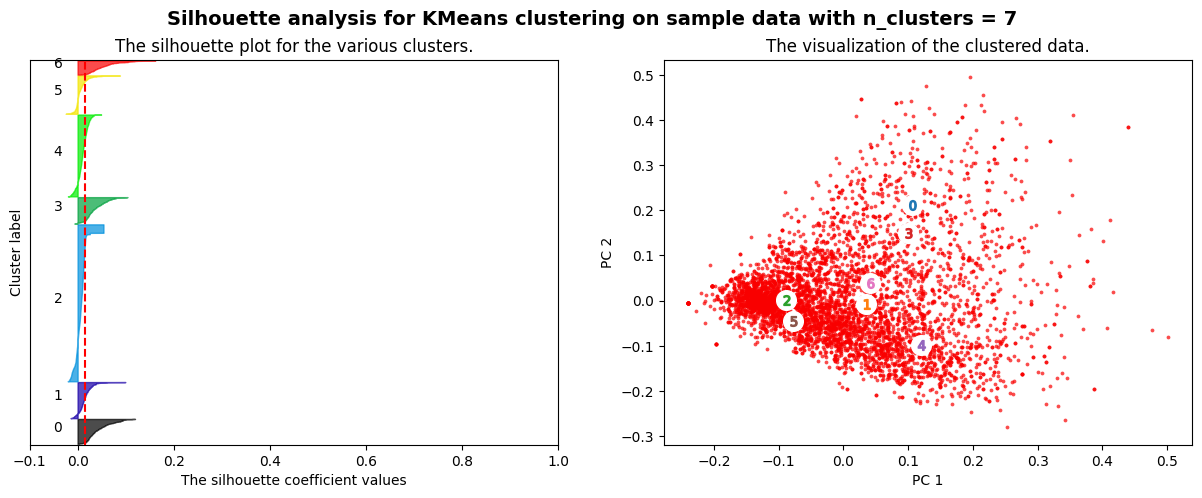

For n_clusters = 7, The average silhouette_score is : 0.015


In [69]:
X = wiaVects.toarray()
plotSilhouette(7, X)

Counterintuitively, 7 clusters seems to have the highest (0.015), which is the best clustering solution.

In [70]:
# try 7 clusters
km = sklearn.cluster.KMeans(n_clusters=7, init='k-means++')
km.fit(wiaVects)

KMeans(n_clusters=7)

In [71]:
wia['km_predic_7'] = km.labels_

# look at the distinguishing features in each cluster
terms = wiaVectorizer.get_feature_names_out()
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(7):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print('\n')

Top terms per cluster:
Cluster 0:
 教授
 面试
 回复
 邮件
 申请
 收到
 推荐信
 学校
 phd
 谢谢


Cluster 1:
 研究
 方向
 相关
 领域
 论文
 专业
 申请
 姐妹
 兴趣
 老师


Cluster 2:
 申请
 phd
 学校
 项目
 硕士
 博士
 offer
 姐妹
 美国
 方向


Cluster 3:
 老师
 学校
 回复
 申请
 方向
 导师
 学生
 邮件
 面试
 感觉


Cluster 4:
 导师
 方向
 老师
 论文
 文章
 学校
 学生
 申请
 项目
 毕业


Cluster 5:
 工作
 专业
 国内
 毕业
 博士
 方向
 本科
 学校
 硕士
 科研


Cluster 6:
 姐妹
 谢谢
 论文
 有没有
 感觉
 分享
 真的
 学习
 rt
 女性




Summarize the essence of the 7 clusters in "Women in Academia":
0. Relation with advisors
1. Graduation
2. Master/Ph.D. application process
3. Future plan
4. Research
5. Feminism
6. Master/Ph.D. application outcome

# Hierarchical Clustering with Wald's Method

Next we approach a hierchical clustering method, which proposes nested clusters at any resolution (at the finest resolution, every document is its own cluster).

Here we must begin by calculating how similar the documents are to one another.

As a first pass, we take our matrix of word counts per document
`newsgroupsTFVects` and create a word occurrence matrix measuring how similar
the documents are to each other based on their number of shared words. (Note one could perform the converse operation, a document occurrence matrix measuring how similar  words are to each other based on their number of collocated documents).

In [72]:
newsgroupsTFVects

<2350x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 55644 stored elements in Compressed Sparse Row format>

In [73]:
newsgroupsTFVects[:100].todense()

matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.02540991, ..., 0.00684522, 0.00362269,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [74]:
newsgroupsCoocMat = newsgroupsTFVects * newsgroupsTFVects.T
#set the diagonal to 0 since we don't care how similar texts are to themselves
newsgroupsCoocMat.setdiag(0)
#Another way of relating the texts is with their cosine similarity
#newsgroupsCosinMat1 = 1 - sklearn.metrics.pairwise.cosine_similarity(newsgroupsTFVects)
#But generally word occurrence is more accurate


/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Now we can compute a tree of nested clusters. Here we will only look at the first 50 texts of each class because drawing the dendrograms can be computationally intensive (and visually complex).

In [75]:
selectIndices = []
indexToCat = []
for c in set(newsgroupsDF['category']):
    selectIndices += list(newsgroupsDF[newsgroupsDF['category'] == c].index)[:50]
    indexToCat += [c] * 50
    #.groupby('category').sum()

In [76]:
subCoocMat = newsgroupsCoocMat[selectIndices,:][:,selectIndices]

In [77]:
linkage_matrix = scipy.cluster.hierarchy.ward(subCoocMat.toarray())
linkage_matrix[:10]

/usr/local/lib/python3.10/dist-packages/scipy/cluster/hierarchy.py:833: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


array([[ 43.        ,  45.        ,   0.        ,   2.        ],
       [ 48.        , 200.        ,   0.        ,   3.        ],
       [ 76.        , 201.        ,   0.        ,   4.        ],
       [155.        , 202.        ,   0.37033177,   5.        ],
       [ 19.        ,  54.        ,   0.40914841,   2.        ],
       [160.        , 194.        ,   0.44134524,   2.        ],
       [ 12.        , 199.        ,   0.45096656,   2.        ],
       [  1.        , 204.        ,   0.4553535 ,   3.        ],
       [ 67.        , 206.        ,   0.4650683 ,   3.        ],
       [152.        , 196.        ,   0.46944808,   2.        ]])

Now we can visualize the tree

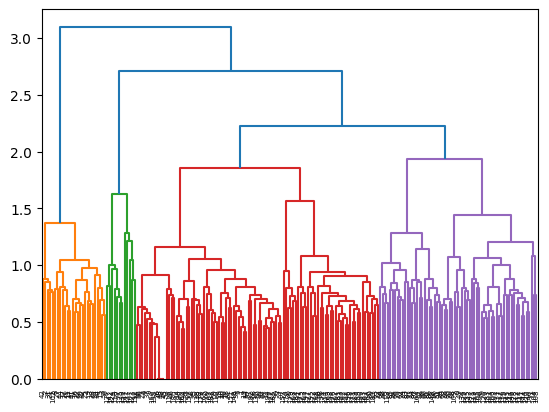

In [78]:
dendDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix, get_leaves=True)

This plot may seem somewhat unwieldy. To make it easier to read, we can cut the tree after a number of branchings.

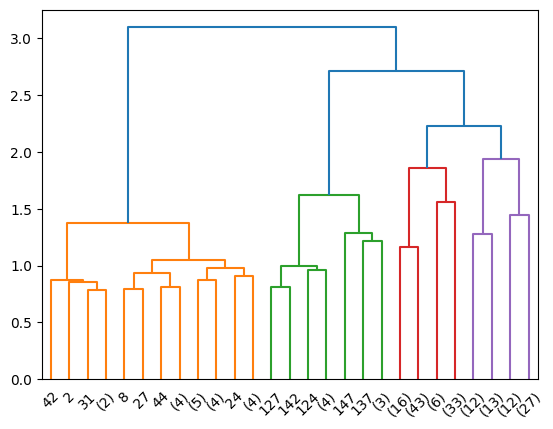

In [79]:
dendrogramDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix, p=4, truncate_mode='level', get_leaves=True)

By default, the tree is colored to show the clusters based on their ['distance'](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html#scipy.cluster.hierarchy.dendrogram) from one another, but there are other ways of forming hierarchical clusters.

Another approach involves cutting the tree into `n` branches. We can do this with [`fcluster()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.fcluster.html#scipy.cluster.hierarchy.fcluster). Lets break the tree into 4 clusters. When we do this with all of the data in the dataframe, as below, we can add those clusters back for detailed evaluation.

In [80]:
hierarchicalClusters = scipy.cluster.hierarchy.fcluster(linkage_matrix, 4, 'maxclust')
hierarchicalClusters

array([4, 3, 1, 1, 1, 3, 3, 3, 1, 3, 3, 1, 3, 1, 3, 1, 1, 1, 3, 3, 1, 1,
       1, 3, 1, 1, 1, 1, 1, 3, 1, 1, 1, 3, 1, 3, 3, 3, 4, 3, 3, 1, 1, 3,
       1, 3, 3, 1, 3, 4, 3, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 4, 4,
       4, 3, 3, 4, 4, 4, 3, 4, 4, 4, 3, 2, 4, 4, 3, 4, 3, 4, 4, 4, 4, 4,
       4, 4, 3, 4, 3, 4, 4, 4, 4, 3, 3, 4, 4, 4, 1, 4, 4, 4, 4, 2, 4, 4,
       3, 4, 4, 4, 4, 4, 3, 4, 2, 4, 4, 4, 3, 2, 2, 2, 4, 2, 4, 4, 3, 4,
       2, 4, 4, 4, 4, 2, 3, 2, 4, 4, 2, 4, 4, 4, 4, 2, 4, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3], dtype=int32)

We can use this *get clusters* like we did with k-means. What if we do the full data set?

In [81]:
linkage_matrix_full = scipy.cluster.hierarchy.ward(newsgroupsCoocMat.toarray())
hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(linkage_matrix_full, 4, 'maxclust')
print("For our complete clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(newsgroupsDF['category'], hierarchicalClusters_full)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(newsgroupsDF['category'], hierarchicalClusters_full)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(newsgroupsDF['category'], hierarchicalClusters_full)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(newsgroupsDF['category'], hierarchicalClusters_full)))

For our complete clusters:
Homogeneity: 0.313
Completeness: 0.370
V-measure: 0.339
Adjusted Rand Score: 0.228


Not quite as good as k-means. Perhaps we've got too many words for Ward or maybe we shouldn't be using TFIDF as that compresses the space. Still, the hierarchical model places constraints on the clustering not present with k-means, which come at a cost. Finally, we can bring those cluster assignments back to the data frame for deeper investigation.

In [82]:
newsgroupsDF['wald_predictions'] = hierarchicalClusters_full
newsgroupsDF

text  \
0     \tIn certain Apple 13" RGB monitors there has ...   
1     Does anyone know how to reach Micron?  I am in...   
2     Hi there!\n\nCould some kind soul tell me what...   
3                                           "auto\nfrom   
4     \n\n    Don't believe the hype. There is no su...   
...                                                 ...   
2345  I was wondering if anyone out in net-land have...   
2346  \n\n\n\n\nI sold my '86 Sprint last April with...   
2347  Actually I wasn't too surprised, since I bough...   
2348  \n\nI couldnt agree more.  That is how it SHOU...   
2349  \nWarren Brown, the Washington Post's auto wri...   

                   category  \
0     comp.sys.mac.hardware   
1     comp.sys.mac.hardware   
2     comp.sys.mac.hardware   
3     comp.sys.mac.hardware   
4     comp.sys.mac.hardware   
...                     ...   
2345              rec.autos   
2346              rec.autos   
2347              rec.autos   
2348              rec.autos   
2349              rec.autos   

                                            source_file  kmeans_predictions  \
0     ../data/scikit_learn_data/20news_home/20news-b...                   1   
1     ../data/scikit_learn_data/20news_home/20news-b...                   1   
2     ../data/scikit_learn_data/20news_home/20news-b...                   1   
3     ../data/scikit_learn_data/20news_home/20news-b...                   1   
4     ../data/scikit_learn_data/20news_home/20news-b...                   1   
...                                                 ...                 ...   
2345  ../data/scikit_learn_data/20news_home/20news-b...                   1   
2346  ../data/scikit_learn_data/20news_home/20news-b...                   0   
2347  ../data/scikit_learn_data/20news_home/20news-b...                   0   
2348  ../data/scikit_learn_data/20news_home/20news-b...                   1   
2349  ../data/scikit_learn_data/20news_home/20news-b...                   1   

      wald_predictions  
0                    4  
1                    4  
2                    4  
3                    4  
4                    4  
...                ...  
2345                 4  
2346                 2  
2347                 2  
2348                 4  
2349                 4  

[2350 rows x 5 columns]

# Now let's do it with Senate press release data

We can also do hierarchical clustering with the Senate data. Let's start by creating the linkage matrix:

In [83]:
exampleCoocMat = exampleTFVects * exampleTFVects.T
exampleCoocMat.setdiag(0)
examplelinkage_matrix = scipy.cluster.hierarchy.ward(exampleCoocMat[:100, :100].toarray())

/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/usr/local/lib/python3.10/dist-packages/scipy/cluster/hierarchy.py:833: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


And visualize the tree:

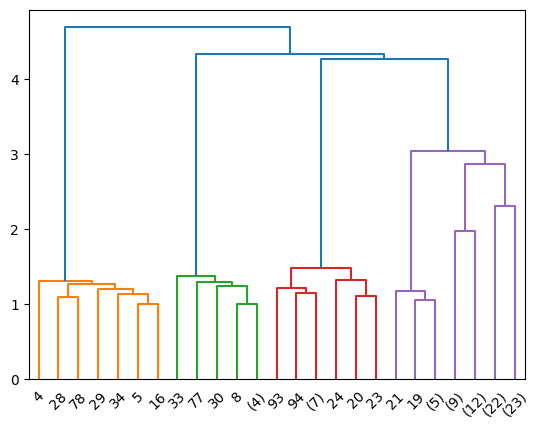

In [84]:
ax = scipy.cluster.hierarchy.dendrogram(examplelinkage_matrix, p=5, truncate_mode='level')

Now let's do it with the entire data frame.

In [85]:
example_linkage_matrix_full = scipy.cluster.hierarchy.ward(exampleCoocMat.toarray())
example_hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(example_linkage_matrix_full, 4, 'maxclust')

## <font color="red">*Exercise 2*</font>

<font color="red">Construct cells immediately below this that hierarchically cluster your documents using two approaches, and visualize them with a tree. Interrogate the recursive cluster contents in terms of both documents and closenesses. What does this nested cluster structure reveal about the organization of documents in your sampled corpora? Moreover, if they do worse than kmeans (as above), why do you think this is the case (hint: using metrics if you have ground truth or silhouette if you do not)?

<font color="red">***Stretch***: Attempt using different distances into your clustering algorithms. (How) do they change the arrangement of clusters?

In [86]:
wia

Title  \
1     精华\n\n\n                    \n                ...   
2     精华\n\n\n                    \n                ...   
3     精华\n\n\n                    \n                ...   
4     精华\n\n\n                    \n                ...   
5     精华\n\n\n                    \n                ...   
...                                                 ...   
5565                                 分享一个本领域senior的采访内容   
5566  精华\n\n\n                    \n                ...   
5567                                  AMA｜美国文理学院做教职（理科）   
5569  精华\n\n\n                    \n                ...   
5570                                  AMA｜美国文理学院做教职（理科）   

                                                   Text   Author Reply  \
1     由猴面包树组员倡议，我们小组建立官方slack交流群啦！为了营造一个更友好安全的交流氛围，目...  Anon加重音  1115   
2     —————————本帖为问卷调查、招募研究对象的集中贴，姐妹们如有问卷调查需要大家帮忙填写或...  Anon加重音    64   
3     前情(意见征集贴) https://www.douban.com/group/topic/1...  Anon加重音    12   
4     论坛第二期分享会她说PhD：不同的人生路径的文字稿和音频分享来啦。非常感谢小组长们的全力支持...   Sophie     2   
5     09/30/21更新: 管理员实在是没有能力及时追踪所有申请相关的帖子，大家有相关的帖子想要...       丸子     6   
...                                                 ...      ...   ...   
5565  这位前辈人非常好，成果很多，采访内容里虽然不少是本领域specific，但是其中关于pick...      路亦槑     1   
5566  组里真是人才济济呀，为了更好地整合与利用资源，将所有AMA帖子集合在这里，方便大家交流学习P...  Anon加重音   NaN   
5567  如题，关于美国文理学院（理科）教职申请、工作日常、工作环境、晋升要求、职业发展，欢迎提问！先...      多喜子     4   
5569  组里真是人才济济呀，为了更好地整合与利用资源，将所有AMA帖子集合在这里，方便大家交流学习P...  Anon加重音   NaN   
5570  如题，关于美国文理学院（理科）教职申请、工作日常、工作环境、晋升要求、职业发展，欢迎提问！先...      多喜子     4   

       LastReply          PublishTime   Like  Collect  Repost  \
1     2023-12-21  2020-10-09 08:25:49  270.0    413.0    44.0   
2     2023-12-01  2020-10-14 12:38:45   12.0     28.0     1.0   
3     2023-07-04  2020-10-10 22:01:03   49.0     64.0     4.0   
4     2023-05-03  2020-11-02 04:35:37   13.0      6.0     NaN   
5     2023-03-25  2020-12-09 03:43:55   27.0    293.0    15.0   
...          ...                  ...    ...      ...     ...   
5565  2020-09-19  2020-09-19 11:27:25    6.0      2.0     2.0   
5566  2020-09-19  2020-09-19 11:15:22   30.0     28.0     2.0   
5567  2020-09-19  2020-09-18 20:49:48    5.0      7.0     1.0   
5569  2020-09-19  2020-09-19 11:15:22   30.0     28.0     2.0   
5570  2020-09-19  2020-09-18 20:49:48    5.0      7.0     1.0   

                                               seg_text  km_predic_4  \
1     由 猴面包树 组员 倡议 ， 我们 小组 建立 官方 slack 交流 群 啦 ！ 为了 营...            3   
2     — — — — — — — — — 本帖 为 问卷调查 、 招募 研究 对象 的 集中 贴 ...            3   
3     前 情 ( 意见 征集 贴 )   https : / / www . douban . c...            3   
4     论坛 第二期 分享 会 她 说 PhD ： 不同 的 人生 路径 的 文字 稿 和 音频 分...            3   
5     09 / 30 / 21 更新 :   管理员 实在 是 没有 能力 及时 追踪 所有 申请...            0   
...                                                 ...          ...   
5565  这位 前辈 人 非常 好 ， 成果 很多 ， 采访 内容 里 虽然 不少 是 本 领域 sp...            3   
5566  组 里 真是 人才济济 呀 ， 为了 更好 地 整合 与 利用 资源 ， 将 所有 AMA ...            0   
5567  如 题 ， 关于 美国 文理学院 （ 理科 ） 教职 申请 、 工作 日常 、 工作 环境 ...            2   
5569  组 里 真是 人才济济 呀 ， 为了 更好 地 整合 与 利用 资源 ， 将 所有 AMA ...            0   
5570  如 题 ， 关于 美国 文理学院 （ 理科 ） 教职 申请 、 工作 日常 、 工作 环境 ...            2   

      km_predic_7  
1               6  
2               1  
3               6  
4               6  
5               2  
...           ...  
5565            6  
5566            5  
5567            5  
5569            5  
5570            5  

[5254 rows x 12 columns]

In [87]:
wiaVects[:200].todense()

matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.06220818, 0.        , 0.07339447, ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [88]:
wiaCoocMat = wiaVects * wiaVects.T
wiaCoocMat.setdiag(0)

/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [89]:
# compute a tree of nested clusters (first 50 texts only)
sub_wiaCoocMat = wiaCoocMat[50:][:50]
linkage_matrix_wia = scipy.cluster.hierarchy.ward(sub_wiaCoocMat.toarray())
linkage_matrix_wia[:10]

array([[45.        , 49.        ,  1.41421356,  2.        ],
       [44.        , 48.        ,  1.41421356,  2.        ],
       [19.        , 24.        ,  1.41421356,  2.        ],
       [16.        , 21.        ,  1.41421356,  2.        ],
       [15.        , 20.        ,  1.41421356,  2.        ],
       [18.        , 23.        ,  1.41421356,  2.        ],
       [17.        , 22.        ,  1.41421356,  2.        ],
       [ 5.        , 25.        ,  1.8614968 ,  2.        ],
       [47.        , 57.        ,  3.15162165,  3.        ],
       [12.        , 31.        ,  3.19004661,  2.        ]])

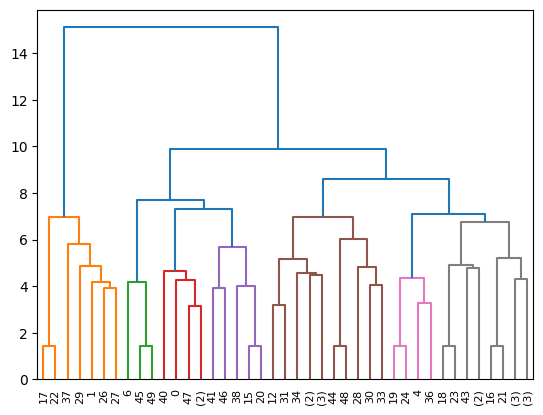

In [90]:
# visualize the tree
dendrogramDat_wia = scipy.cluster.hierarchy.dendrogram(linkage_matrix_wia, p=6, truncate_mode='level', get_leaves=True, color_threshold=7)
# by setting color_threshold, I can limit the cluster number as 7, which is comparable with the k-means method optimized clustering

In [91]:
hierarchicalClusters_wia = scipy.cluster.hierarchy.fcluster(linkage_matrix_wia, 7, 'maxclust')
hierarchicalClusters_wia

array([3, 1, 7, 7, 6, 3, 2, 5, 7, 7, 7, 7, 5, 5, 5, 4, 7, 1, 7, 6, 4, 7,
       1, 7, 6, 3, 1, 1, 5, 1, 5, 5, 5, 5, 5, 7, 6, 1, 4, 5, 3, 4, 7, 7,
       5, 2, 4, 3, 5, 2], dtype=int32)

Unfortunately, since my dataset has no category variables, the comparison of accuracy with k-means method can not be conducted.🥲

In [92]:
# the full dataset
linkage_matrix_wia_full = scipy.cluster.hierarchy.ward(wiaCoocMat.toarray())
hierarchicalClusters_wia_full = scipy.cluster.hierarchy.fcluster(linkage_matrix_wia_full, 7, 'maxclust')

/usr/local/lib/python3.10/dist-packages/scipy/cluster/hierarchy.py:833: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


In [93]:
wia['wald_predictions'] = hierarchicalClusters_wia_full
wia[:20]

Title  \
1   精华\n\n\n                    \n                ...   
2   精华\n\n\n                    \n                ...   
3   精华\n\n\n                    \n                ...   
4   精华\n\n\n                    \n                ...   
5   精华\n\n\n                    \n                ...   
6   精华\n\n\n                    \n                ...   
7   精华\n\n\n                    \n                ...   
8   精华\n\n\n                    \n                ...   
9   精华\n\n\n                    \n                ...   
10  精华\n\n\n                    \n                ...   
11             急急国王提问：25fall无paper应该继续all in申博还是速度找实习   
12                        本人研三 民族学 想申请人类学PhD 求助各位友友‼️   
13                  和同学组队中了ica单数由于对方想要所有赞助和报销，希望我不...   
14                                           要不要继续搞科研   
15                                      Lingvist拼团五缺一   
16                                陆本来加拿大读研，就读体验上升两个台阶   
17                                      求助🎩申请视频剪辑专业指导   
18                                         是否应该转硕出国呢？   
19                                          Mplus相关问题   
20                              如何对自己学术能力进行较为准确地定位和认知   

                                                 Text       Author Reply  \
1   由猴面包树组员倡议，我们小组建立官方slack交流群啦！为了营造一个更友好安全的交流氛围，目...      Anon加重音  1115   
2   —————————本帖为问卷调查、招募研究对象的集中贴，姐妹们如有问卷调查需要大家帮忙填写或...      Anon加重音    64   
3   前情(意见征集贴) https://www.douban.com/group/topic/1...      Anon加重音    12   
4   论坛第二期分享会她说PhD：不同的人生路径的文字稿和音频分享来啦。非常感谢小组长们的全力支持...       Sophie     2   
5   09/30/21更新: 管理员实在是没有能力及时追踪所有申请相关的帖子，大家有相关的帖子想要...           丸子     6   
6   以下表格列出的情况只与组规中判定为“伸手党”一项有关，其他组规中规定的禁止项内容将直接删除。...           丸子    15   
7   12.10 将本贴的内容整理为豆列，以方便大家查看：https://www.douban.c...          doe    54   
8   前言：感谢各位组员的热心分享和疑惑解答，小组的一切一切都是承蒙各位的慷慨和热心，谢谢大家也希...  your chance    20   
9   入组申请回答以下三个问题：本帖中找到的由14个汉字组成的暗号入组理由 (一两句话即可)你入组...      Anon加重音    30   
10  秉承着我们小组【善用组内搜索、拒绝伸手党】的优良传统，受姐妹小组women in tech管...      Anon加重音    10   
11  1️⃣ 个人背景本人本科双非，竞赛保研211理工科，目前无发表基本上无项目经验。一直想读博，...        加州龙须面    12   
12  本人硕士就读于一所民族211，专业是少数民族经济，属于民族学，是民族学与经济学的交叉学科。硕...         momo     9   
13  新问题：考虑到现在已经彻底闹翻了（她说自己没钱想要所有的funding和报销，其实一直吵的也...         momo     6   
14  我，本科985院校保研到国内TOP5高校直博（相当于硕博连读），目前在某省内TOP5高校(非...       进化中的皮蛋    20   
15  蹲一个iOS端姐妹一起拼Lingvist家庭版会员！每个人只需要88块就可以一整年会员啦，语...        陪小狗遛弯   NaN   
16  两个导师，一个五十岁一个六十岁，依然在科研一线亲自写文章写书带学生。每周和我二对一meeti...       埋头驱赶空荡   NaN   
17  关于科研项目或🎩申请的视频录音剪辑，友友们有没有觉得还不错的公司或专业人士（曾经帮助自己或老...      Hoodman   NaN   
18  最近实在太纠结，太苦恼，所以想听听大家如果处于这种情况会如何选择。lz目前直博二年级，人文社...        用户已睡觉     4   
19  有没有用mplus跑潜变量增长混合模型的姐妹，模型拟合不好，模型拟合最终结果χ2=57.55...      Maruko🌻     1   
20  各位前辈好，我是一名社科类研一硕士，近期有一些因参加年会/论坛而产生的疑惑，想向各位前辈寻求...       寡王一路硕博    17   

      LastReply          PublishTime   Like  Collect  Repost  \
1    2023-12-21  2020-10-09 08:25:49  270.0    413.0    44.0   
2    2023-12-01  2020-10-14 12:38:45   12.0     28.0     1.0   
3    2023-07-04  2020-10-10 22:01:03   49.0     64.0     4.0   
4    2023-05-03  2020-11-02 04:35:37   13.0      6.0     NaN   
5    2023-03-25  2020-12-09 03:43:55   27.0    293.0    15.0   
6    2022-12-09  2020-11-28 08:53:06   23.0      5.0     NaN   
7    2022-06-21  2020-09-23 10:49:44  557.0   5454.0   481.0   
8    2021-09-13  2020-11-14 20:42:09  131.0   1422.0    82.0   
9    2021-05-11  2020-09-25 07:33:29  444.0    531.0   115.0   
10   2021-04-10  2021-03-29 11:48:54   16.0      1.0     NaN   
11  01-13 14:31  2024-01-11 15:15:08    4.0      NaN     1.0   
12  01-13 14:18  2023-12-27 16:22:49    7.0     11.0     NaN   
13  01-13 14:18  2024-01-11 21:09:06    NaN      NaN     NaN   
14  01-12 19:09  2024-01-08 20:29:19   13.0      9.0     2.0   
15  01-12 16:57  2024-01-12 16:57:19    NaN      NaN     NaN   
16  01-12 14:16  2024-01-12 14:16:18    2.0      1.0     NaN   
17  01-12 13:06  2024-01-12 13:06:02    NaN      NaN     NaN   
18  01-12 10:04  2024-01-10 01:52:58    1.0      2.0     NaN   
19  01-12 08:49  2024-01-11 21:18:34 

# Gensim

To do topic modeling we will also be using data from the [grimmer press releases corpus](ttps://github.com/lintool/GrimmerSenatePressReleases). To use the texts with gensim we need to create a `corpua` object, this takes a few steps. First we create a `Dictionary` that maps tokens to ids.

Here again we make use of `lucem_illud` functions. The source code of both of these is in [processing.py](https://github.com/UChicago-Computational-Content-Analysis/lucem_illud/blob/main/lucem_illud/processing.py).

In [94]:
#Apply our functions
senReleasesTraining['tokenized_text'] = senReleasesTraining['text'].apply(lambda x: lucem_illud.word_tokenize(x))
senReleasesTraining['normalized_tokens'] = senReleasesTraining['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))

/usr/local/lib/python3.10/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [95]:
senReleasesTraining[::100]

Unnamed: 0                                       download_url  \
0             0  https://raw.githubusercontent.com/lintool/Grim...   
100         101  https://raw.githubusercontent.com/lintool/Grim...   
200         201  https://raw.githubusercontent.com/lintool/Grim...   
300         301  https://raw.githubusercontent.com/lintool/Grim...   
400         401  https://raw.githubusercontent.com/lintool/Grim...   
500         501  https://raw.githubusercontent.com/lintool/Grim...   
600         601  https://raw.githubusercontent.com/lintool/Grim...   
700         701  https://raw.githubusercontent.com/lintool/Grim...   
800         801  https://raw.githubusercontent.com/lintool/Grim...   
900         901  https://raw.githubusercontent.com/lintool/Grim...   

                                              html_url  \
0    https://github.com/lintool/GrimmerSenatePressR...   
100  https://github.com/lintool/GrimmerSenatePressR...   
200  https://github.com/lintool/GrimmerSenatePressR...   
300  https://github.com/lintool/GrimmerSenatePressR...   
400  https://github.com/lintool/GrimmerSenatePressR...   
500  https://github.com/lintool/GrimmerSenatePressR...   
600  https://github.com/lintool/GrimmerSenatePressR...   
700  https://github.com/lintool/GrimmerSenatePressR...   
800  https://github.com/lintool/GrimmerSenatePressR...   
900  https://github.com/lintool/GrimmerSenatePressR...   

                       name                                path  \
0    01Apr2005Kennedy14.txt  raw/Kennedy/01Apr2005Kennedy14.txt   
100   02Feb2006Kennedy8.txt   raw/Kennedy/02Feb2006Kennedy8.txt   
200   04May2006Kennedy7.txt   raw/Kennedy/04May2006Kennedy7.txt   
300   06Jun2006Kennedy5.txt   raw/Kennedy/06Jun2006Kennedy5.txt   
400   08Dec2006Kennedy4.txt   raw/Kennedy/08Dec2006Kennedy4.txt   
500  09Nov2005Kennedy10.txt  raw/Kennedy/09Nov2005Kennedy10.txt   
600   11Nov2005Kennedy5.txt   raw/Kennedy/11Nov2005Kennedy5.txt   
700   13Jun2006Kennedy0.txt   raw/Kennedy/13Jun2006Kennedy0.txt   
800   15Dec2005Kennedy4.txt   raw/Kennedy/15Dec2005Kennedy4.txt   
900  16May2007Kennedy10.txt  raw/Kennedy/16May2007Kennedy10.txt   

                                                  text targetSenator  \
0             FOR IMMEDIATE RELEASE   FOR IMMEDIATE...       Kennedy   
100           FOR IMMEDIATE RELEASE  Washington  DC...       Kennedy   
200           FOR IMMEDIATE RELEASE      FOR IMMEDI...       Kennedy   
300           FOR IMMEDIATE RELEASE  FOR IMMEDIATE ...       Kennedy   
400           FOR IMMEDIATE RELEASE  Washington  D ...       Kennedy   
500           FOR IMMEDIATE RELEASE     Washington ...       Kennedy   
600           FOR IMMEDIATE RELEASE     On this Vet...       Kennedy   
700           FOR IMMEDIATE RELEASE  FOR IMMEDIATE ...       Kennedy   
800           FOR IMMEDIATE RELEASE     Washington ...       Kennedy   
900           FOR IMMEDIATE RELEASE  WASHINGTON  D ...       Kennedy   

     kmeans_predictions                                     tokenized_text  \
0                     2  [FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...   
100                   1  [FOR, IMMEDIATE, RELEASE, Washington, DC, Toda...   
200                   1  [FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...   
300                   1  [FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...   
400                   2  [FOR, IMMEDIATE, RELEASE, Washington, D, C, To...   
500                   1  [FOR, IMMEDIATE, RELEASE, Washington, DC, Toda...   
600                   0  [FOR, IMMEDIATE, RELEASE, On, this, Veteran, s...   
700                   1  [FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...   
800                   1  [FOR, IMMEDIATE, RELEASE, Washington, DC, Toda...   
900                   1  [FOR, IMMEDIATE, RELEASE, WASHINGTON, D, C, Se...   

                                     normalized_tokens  
0    [immediate, release, immediate, release, conta...  
100  [immediate, release, washington, dc, today, se...  
200  [immediate, release, immediat

In [96]:
def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]

senReleasesTraining['reduced_tokens'] = senReleasesTraining['normalized_tokens'].apply(lambda x: dropMissing(x, senTFVectorizer.vocabulary_.keys()))

In [97]:
dictionary = gensim.corpora.Dictionary(senReleasesTraining['reduced_tokens'])

Then for each of the texts we create a list of tuples containing each token and its count. We will only use the first half of our dataset for now and will save the remainder for testing.

In [98]:
corpus = [dictionary.doc2bow(text) for text in senReleasesTraining['reduced_tokens']]

Then we serialize the corpus as a file and load it. This is an important step when the corpus is large.

In [99]:
gensim.corpora.MmCorpus.serialize('senate.mm', corpus)
senmm = gensim.corpora.MmCorpus('senate.mm')

Now we have a correctly formatted corpus that we can use for topic modeling and induction.

In [100]:
senlda = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, alpha='auto', eta='auto')

We can inspect the degree to which distinct texts load on different topics. Here is one of the texts from the training set:

In [101]:
sen1Bow = dictionary.doc2bow(senReleasesTraining['reduced_tokens'][0])
sen1lda = senlda[sen1Bow]
print("The topics of the text: {}".format(senReleasesTraining['name'][0]))
print("are: {}".format(sen1lda))

The topics of the text: 01Apr2005Kennedy14.txt
are: [(8, 0.2896183), (9, 0.68567896)]


We can now see which topics our model predicts press releases load on and make this into a `dataFrame` for later analysis.

In [102]:
ldaDF = pandas.DataFrame({
        'name' : senReleasesTraining['name'],
        'topics' : [senlda[dictionary.doc2bow(l)] for l in senReleasesTraining['reduced_tokens']]
    })

This is a bit unwieldy so lets make each topic its own column:

In [103]:
#Dict to temporally hold the probabilities
topicsProbDict = {i : [0] * len(ldaDF) for i in range(senlda.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(senlda.num_topics):
    ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

ldaDF[1::100]

name  \
1    01Aug2005Kennedy12.txt   
101  02Feb2007Kennedy10.txt   
201   04May2006Kennedy8.txt   
301   06Jun2007Kennedy1.txt   
401   08Feb2005Kennedy0.txt   
501  09Nov2005Kennedy11.txt   
601   11Nov2005Kennedy6.txt   
701   13Jun2006Kennedy1.txt   
801   15Dec2005Kennedy5.txt   
901   16May2007Kennedy5.txt   

                                                topics   topic_0   topic_1  \
1                                     [(8, 0.9726648)]  0.000000  0.000000   
101                [(0, 0.032161545), (4, 0.96333903)]  0.032162  0.000000   
201                 [(3, 0.18340096), (4, 0.81454545)]  0.000000  0.000000   
301  [(3, 0.7640002), (7, 0.20416836), (9, 0.030324...  0.000000  0.000000   
401  [(1, 0.74928063), (4, 0.13679248), (6, 0.03854...  0.000000  0.749281   
501                                  [(2, 0.95588183)]  0.000000  0.000000   
601                                  [(3, 0.97196496)]  0.000000  0.000000   
701                                   [(3, 0.9971266)]  0.000000  0.000000   
801  [(4, 0.36852336), (8, 0.04838941), (9, 0.57985...  0.000000  0.000000   
901                                  [(7, 0.95629424)]  0.000000  0.000000   

      topic_2   topic_3   topic_4  topic_5   topic_6   topic_7   topic_8  \
1    0.000000  0.000000  0.000000      0.0  0.000000  0.000000  0.972665   
101  0.000000  0.000000  0.963339      0.0  0.000000  0.000000  0.000000   
201  0.000000  0.183401  0.814545      0.0  0.000000  0.000000  0.000000   
301  0.000000  0.764000  0.000000      0.0  0.000000  0.204168  0.000000   
401  0.000000  0.000000  0.136792      0.0  0.038542  0.071074  0.000000   
501  0.955882  0.000000  0.000000      0.0  0.000000  0.000000  0.000000   
601  0.000000  0.971965  0.000000      0.0  0.000000  0.000000  0.000000   
701  0.000000  0.997127  0.000000      0.0  0.000000  0.000000  0.000000   
801  0.000000  0.000000  0.368523      0.0  0.000000  0.000000  0.048389   
901  0.000000  0.000000  0.000000      0.0  0.000000  0.956294  0.000000   

      topic_9  
1    0.000000  
101  0.000000  
201  0.000000  
301  0.030324  
401  0.000000  
501  0.000000  
601  0.000000  
701  0.000000  
801  0.579854  
901  0.000000

Now let's visualize this for several (e.g., 10) documents in the corpus. First we'll subset the data:

In [104]:
ldaDFV = ldaDF[:10][['topic_%d' %x for x in range(10)]]
ldaDFVisN = ldaDF[:10][['name']]
ldaDFVis = ldaDFV.values
ldaDFVisNames = ldaDFVisN.values
ldaDFV

topic_0   topic_1  topic_2  topic_3   topic_4  topic_5  topic_6   topic_7  \
0  0.000000  0.000000      0.0      0.0  0.000000      0.0      0.0  0.000000   
1  0.000000  0.000000      0.0      0.0  0.000000      0.0      0.0  0.000000   
2  0.000000  0.993651      0.0      0.0  0.000000      0.0      0.0  0.000000   
3  0.000000  0.000000      0.0      0.0  0.000000      0.0      0.0  0.000000   
4  0.000000  0.000000      0.0      0.0  0.499622      0.0      0.0  0.000000   
5  0.000000  0.000000      0.0      0.0  0.553910      0.0      0.0  0.438621   
6  0.989554  0.000000      0.0      0.0  0.000000      0.0      0.0  0.000000   
7  0.000000  0.967921      0.0      0.0  0.000000      0.0      0.0  0.000000   
8  0.000000  0.692365      0.0      0.0  0.000000      0.0      0.0  0.000000   
9  0.000000  0.967951      0.0      0.0  0.000000      0.0      0.0  0.000000   

    topic_8   topic_9  
0  0.275949  0.699348  
1  0.972665  0.000000  
2  0.000000  0.000000  
3  0.993820  0.000000  
4  0.356666  0.141795  
5  0.000000  0.000000  
6  0.000000  0.000000  
7  0.000000  0.000000  
8  0.303568  0.000000  
9  0.000000  0.000000

First we can visualize as a stacked bar chart:

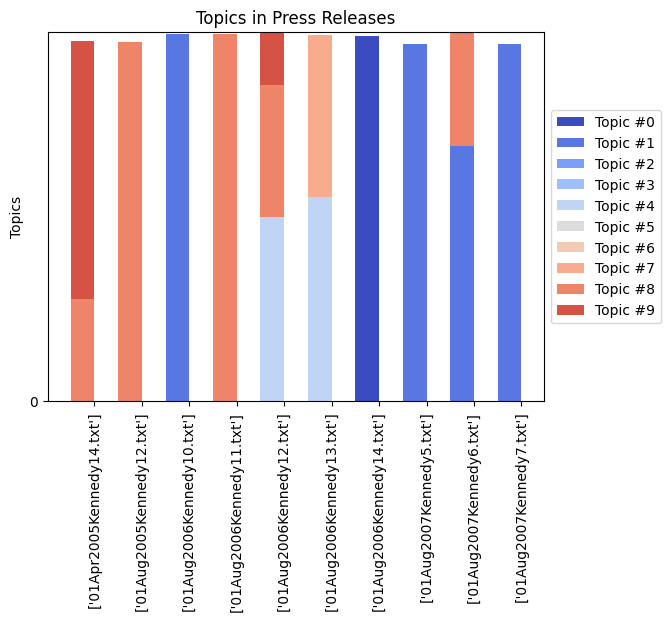

In [105]:
N = 10
ind = np.arange(N)
K = senlda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, ldaDFVis[:, k], width, color=color)
    else:
        p = plt.bar(ind, ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += ldaDFVis[:, k]
    plots.append(p)


plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.ylabel('Topics')

plt.title('Topics in Press Releases')
plt.xticks(ind+width/2, ldaDFVisNames, rotation='vertical')

plt.yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

plt.show()

We can also visualize as a heat map:

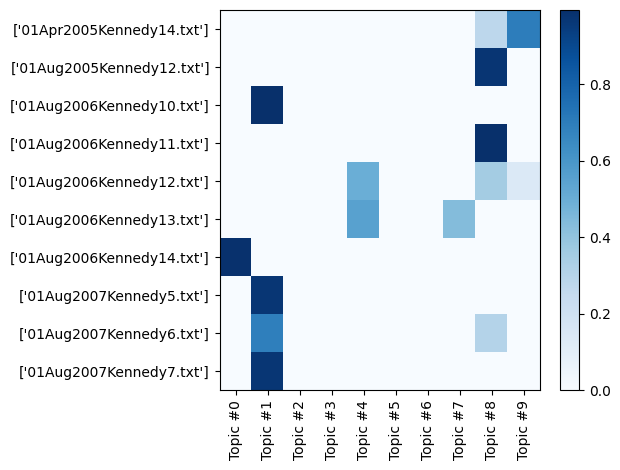

In [106]:
plt.pcolor(ldaDFVis, norm=None, cmap='Blues')
plt.yticks(np.arange(ldaDFVis.shape[0])+0.5, ldaDFVisNames);
plt.xticks(np.arange(ldaDFVis.shape[1])+0.5, topic_labels);

# flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
plt.gca().invert_yaxis()

# rotate the ticks on the x-axis
plt.xticks(rotation=90)

# add a legend
plt.colorbar(cmap='Blues')
plt.tight_layout()  # fixes margins
plt.show()

We can also look at the top words from each topic to get a sense of the semantic (or syntactic) domain they represent. To look at the terms with the highest LDA weight in topic `1` we can do the following:

In [107]:
senlda.show_topic(1)

[('loan', 0.005726104),
 ('loans', 0.004510027),
 ('head', 0.0044723456),
 ('lenders', 0.0044432017),
 ('lender', 0.0028920365),
 ('development', 0.0027382718),
 ('colleges', 0.00243257),
 ('immigrants', 0.0023505564),
 ('immigration', 0.0022145435),
 ('wage', 0.0021382405)]

And if we want to make a dataFrame:

In [108]:
topicsDict = {}
for topicNum in range(senlda.num_topics):
    topicWords = [w for w, p in senlda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pandas.DataFrame(topicsDict)
wordRanksDF

Topic_0      Topic_1       Topic_2      Topic_3   Topic_4  \
0      violence         loan          loan     asbestos      wage   
1        liheap        loans       lenders         fund   minimum   
2  intelligence         head      medicare  immigration  coverage   
3       science      lenders       pension     medicare    mental   
4      soldiers       lender  intelligence        trust  medicare   
5           fda  development    retirement     coverage     loans   
6         iraqi     colleges     insurance      victims      loan   
7        energy   immigrants   immigration    insurance       tax   
8          fund  immigration         loans   immigrants      cell   
9      asbestos         wage         drugs         stem      stem   

        Topic_5      Topic_6      Topic_7   Topic_8      Topic_9  
0        mental         head  immigration       fda   bankruptcy  
1       victims    insurance          fda  asbestos         head  
2       ireland         wage         wage      loan         wage  
3   association      minimum   immigrants     trust         chip  
4      asbestos     teachers      minimum   victims  immigration  
5  intelligence     coverage         loan      fund      minimum  
6     insurance     medicare     attorney     judge     coverage  
7      northern  association    insurance  coverage     medicaid  
8    presidents       mental         head     drugs        judge  
9          head      victims      section  medicaid    insurance

We can see that several of the topics have the same top words, but there are definitely differences. We can try and make the topics more distinct by changing the $\alpha$ and $\eta$ parameters of the model. $\alpha$ controls the sparsity of document-topic loadings, and $\eta$ controls the sparsity of topic-word loadings.

We can make a visualization of the distribution of words over any single topic.

<Figure size 640x480 with 0 Axes>

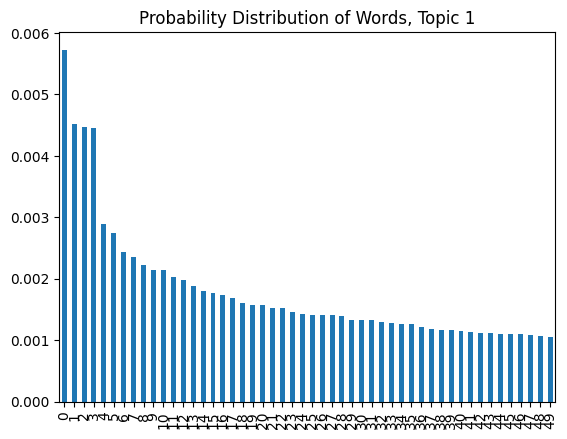

In [109]:
topic1_df = pandas.DataFrame(senlda.show_topic(1, topn=50))
plt.figure()
topic1_df.plot.bar(legend = False)
plt.title('Probability Distribution of Words, Topic 1')
plt.show()

See how different $\eta$ values can change the shape of the distribution.

In [110]:
senlda1 = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, eta = 0.00001)
senlda2 = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, eta = 0.9)

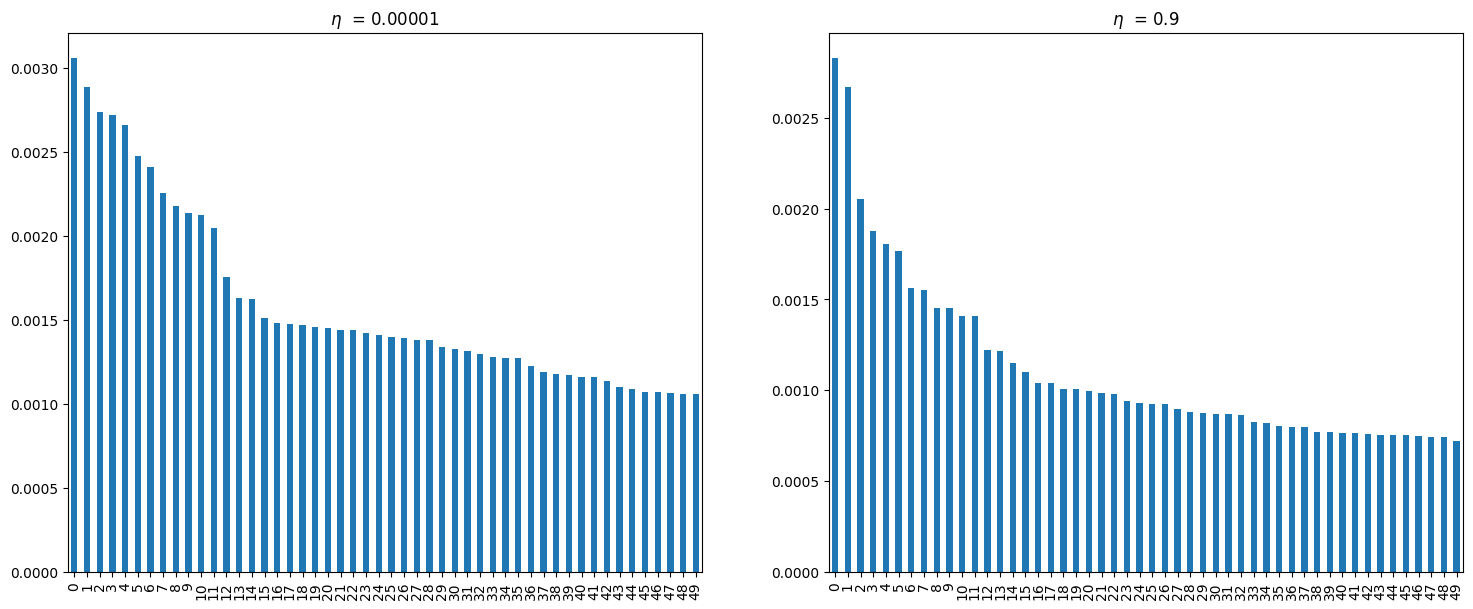

In [111]:
topic11_df = pandas.DataFrame(senlda1.show_topic(1, topn=50))
topic21_df = pandas.DataFrame(senlda2.show_topic(1, topn=50))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
topic11_df.plot.bar(legend = False, ax = ax1, title = '$\eta$  = 0.00001')
topic21_df.plot.bar(legend = False, ax = ax2, title = '$\eta$  = 0.9')
plt.show()

### Heirarchial Dirichlet Process

We use LDA topic modeling above, but a similar alternative model you may run across is Hierarchical Dirichlet Processes, a nonparametric generalization of LDA. See, for example, [Teodoridis et al 2020](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3596233). One difference is how the researcher selects the number of topics.

In [112]:
from gensim.models import HdpModel

In [113]:
hdpmodel = HdpModel(corpus=corpus, id2word=dictionary)

In [114]:
hdpmodel.print_topics()

[(0,
  '0.003*head + 0.003*wage + 0.003*minimum + 0.002*tobacco + 0.002*victims + 0.002*mental + 0.002*insurance + 0.002*asbestos + 0.002*judge + 0.002*coverage'),
 (1,
  '0.009*asbestos + 0.006*victims + 0.006*fund + 0.005*trust + 0.004*compensation + 0.002*lung + 0.002*exposure + 0.002*cancer + 0.002*cases + 0.002*disease'),
 (2,
  '0.005*loan + 0.005*medicaid + 0.004*liheap + 0.003*medicare + 0.003*cuts + 0.003*gulf + 0.002*coast + 0.002*loans + 0.002*region + 0.002*director'),
 (3,
  '0.003*cuts + 0.002*global + 0.002*medicaid + 0.002*affirmative + 0.002*wage + 0.002*math + 0.002*skills + 0.002*affordable + 0.002*science + 0.001*track'),
 (4,
  '0.006*immigration + 0.006*immigrants + 0.005*documents + 0.003*document + 0.003*undocumented + 0.002*border + 0.002*crandall + 0.002*referring + 0.002*canyon + 0.002*concerning'),
 (5,
  '0.020*loan + 0.012*loans + 0.011*lenders + 0.008*lender + 0.006*colleges + 0.005*preferred + 0.005*aid + 0.005*rates + 0.004*direct + 0.004*borrowers'),
 

Gensim sets the default number of topics as 150. This [stack overflow link](https://stackoverflow.com/questions/31543542/hierarchical-dirichlet-process-gensim-topic-number-independent-of-corpus-size) walks you through how to truncate these topics.

In [115]:
hdptexts = hdpmodel[corpus]

In [116]:
hdptexts[0]

[(0, 0.1602078685623771), (91, 0.8222192801777592)]

This [HDP tutorial](https://towardsdatascience.com/dont-be-afraid-of-nonparametric-topic-models-part-2-python-e5666db347a) walks us through alternative HDP implementations outside of gensim.

## <font color="red">*Exercise 3*</font>

<font color="red">Construct cells immediately below this that topic model documents related to your anticipated final project. Interrogate and visually plot (e.g., as a bar graph?) the topic-word loadings and the document-topic loadings. What does this topic structure reveal about the distribution of contents across your documents? Systematically vary the $\alpha$, $\eta$, and topic number of the model for your text and describe in detail whether and how these changes led to distinctive outcomes, visible to you as analyst.  

<font color="red">**Stretch**: Cluster your documents, but instead of using words alone, use their topic loadings as an additional set of features. Do these topic loadings increase the apparent semantic coherence of your clusters?</font>

In [117]:
wia[:3]

Title  \
1  精华\n\n\n                    \n                ...   
2  精华\n\n\n                    \n                ...   
3  精华\n\n\n                    \n                ...   

                                                Text   Author Reply  \
1  由猴面包树组员倡议，我们小组建立官方slack交流群啦！为了营造一个更友好安全的交流氛围，目...  Anon加重音  1115   
2  —————————本帖为问卷调查、招募研究对象的集中贴，姐妹们如有问卷调查需要大家帮忙填写或...  Anon加重音    64   
3  前情(意见征集贴) https://www.douban.com/group/topic/1...  Anon加重音    12   

    LastReply          PublishTime   Like  Collect  Repost  \
1  2023-12-21  2020-10-09 08:25:49  270.0    413.0    44.0   
2  2023-12-01  2020-10-14 12:38:45   12.0     28.0     1.0   
3  2023-07-04  2020-10-10 22:01:03   49.0     64.0     4.0   

                                            seg_text  km_predic_4  \
1  由 猴面包树 组员 倡议 ， 我们 小组 建立 官方 slack 交流 群 啦 ！ 为了 营...            3   
2  — — — — — — — — — 本帖 为 问卷调查 、 招募 研究 对象 的 集中 贴 ...            3   
3  前 情 ( 意见 征集 贴 )   https : / / www . douban . c...            3   

   km_predic_7  wald_predictions  
1            6                 2  
2            1                 2  
3            6                 2

In [118]:
wia['tokenized_text'] = wia['Text'].apply(lambda x: list(jieba.cut(x.strip())))
wia[:3]

Title  \
1  精华\n\n\n                    \n                ...   
2  精华\n\n\n                    \n                ...   
3  精华\n\n\n                    \n                ...   

                                                Text   Author Reply  \
1  由猴面包树组员倡议，我们小组建立官方slack交流群啦！为了营造一个更友好安全的交流氛围，目...  Anon加重音  1115   
2  —————————本帖为问卷调查、招募研究对象的集中贴，姐妹们如有问卷调查需要大家帮忙填写或...  Anon加重音    64   
3  前情(意见征集贴) https://www.douban.com/group/topic/1...  Anon加重音    12   

    LastReply          PublishTime   Like  Collect  Repost  \
1  2023-12-21  2020-10-09 08:25:49  270.0    413.0    44.0   
2  2023-12-01  2020-10-14 12:38:45   12.0     28.0     1.0   
3  2023-07-04  2020-10-10 22:01:03   49.0     64.0     4.0   

                                            seg_text  km_predic_4  \
1  由 猴面包树 组员 倡议 ， 我们 小组 建立 官方 slack 交流 群 啦 ！ 为了 营...            3   
2  — — — — — — — — — 本帖 为 问卷调查 、 招募 研究 对象 的 集中 贴 ...            3   
3  前 情 ( 意见 征集 贴 )   https : / / www . douban . c...            3   

   km_predic_7  wald_predictions  \
1            6                 2   
2            1                 2   
3            6                 2   

                                      tokenized_text  
1  [由, 猴面包树, 组员, 倡议, ，, 我们, 小组, 建立, 官方, slack, 交流...  
2  [—, —, —, —, —, —, —, —, —, 本帖, 为, 问卷调查, 、, 招募...  
3  [前, 情, (, 意见, 征集, 贴, ),  , https, :, /, /, www...

In [119]:
# design a function for eliminate chinese stopwords in tokenized text
cn_stopwords.extend(["…", ":", "\n", ' ']) # this is inspired by the first attempt of topic modeling, which generated topics containing meaningless words
def elim_cn_stopwords(list):
  new_list = []
  for word in list:
    if word not in cn_stopwords:
      new_list.append(word)
  return new_list

In [120]:
wia['tokenized_text'] = wia['tokenized_text'].apply(lambda x: elim_cn_stopwords(x))
wia[:3]

Title  \
1  精华\n\n\n                    \n                ...   
2  精华\n\n\n                    \n                ...   
3  精华\n\n\n                    \n                ...   

                                                Text   Author Reply  \
1  由猴面包树组员倡议，我们小组建立官方slack交流群啦！为了营造一个更友好安全的交流氛围，目...  Anon加重音  1115   
2  —————————本帖为问卷调查、招募研究对象的集中贴，姐妹们如有问卷调查需要大家帮忙填写或...  Anon加重音    64   
3  前情(意见征集贴) https://www.douban.com/group/topic/1...  Anon加重音    12   

    LastReply          PublishTime   Like  Collect  Repost  \
1  2023-12-21  2020-10-09 08:25:49  270.0    413.0    44.0   
2  2023-12-01  2020-10-14 12:38:45   12.0     28.0     1.0   
3  2023-07-04  2020-10-10 22:01:03   49.0     64.0     4.0   

                                            seg_text  km_predic_4  \
1  由 猴面包树 组员 倡议 ， 我们 小组 建立 官方 slack 交流 群 啦 ！ 为了 营...            3   
2  — — — — — — — — — 本帖 为 问卷调查 、 招募 研究 对象 的 集中 贴 ...            3   
3  前 情 ( 意见 征集 贴 )   https : / / www . douban . c...            3   

   km_predic_7  wald_predictions  \
1            6                 2   
2            1                 2   
3            6                 2   

                                      tokenized_text  
1  [猴面包树, 组员, 倡议, 小组, 建立, 官方, slack, 交流, 群, 营造, 更...  
2  [本帖, 问卷调查, 招募, 研究, 对象, 贴, 姐妹, 问卷调查, 帮忙, 填写, 招募...  
3  [前, 情, 意见, 征集, 贴, https, www, douban, group, t...

In [121]:
# create a copora
dictionary_wia = gensim.corpora.Dictionary(wia['tokenized_text'])
# use the first half as the training data
corpus = [dictionary_wia.doc2bow(text) for text in wia['tokenized_text']]

In [122]:
# serialize the corpus as a file and load it
gensim.corpora.MmCorpus.serialize('wia.mm', corpus)
wia_mm = gensim.corpora.MmCorpus('wia.mm')

In [123]:
wialda = gensim.models.ldamodel.LdaModel(corpus=wia_mm, id2word=dictionary_wia, num_topics=10, alpha='auto', eta='auto')

In [124]:
wialdaDF = pandas.DataFrame({
        'title' : wia['Title'],
        'topics' : [wialda[dictionary.doc2bow(l)] for l in wia['tokenized_text']]
    })

In [125]:
#Dict to temporally hold the probabilities
wiatopicsProbDict = {i : [0] * len(wialdaDF) for i in range(wialda.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(wialdaDF['topics']):
    for topicNum, prob in topicTuples:
        wiatopicsProbDict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(wialda.num_topics):
    wialdaDF['topic_{}'.format(topicNum)] = wiatopicsProbDict[topicNum]

wialdaDF[1::300]

title  \
2     精华\n\n\n                    \n                ...   
312                           想去加拿大读博，提前一年进该组做科研助理是否可行？   
623                                              性别主义研究   
933                                            该怎么回复导师呢   
1247               HKSYU 社会学系招聘研究助理：文化遗产/数字遗产/虚拟博物馆/...   
1558                              北欧排名300多大学的岗位制博士可以去吗？   
1870                               phd申请要求看MA的论文 超级慌怎么破   
2185                              未来想run呜呜呜 硕士专业选择求助sos   
2499                                      关于和教授coauthor   
2813                                           PhD入学前焦虑   
3133                          想组个小型单身硕博科研狗姐妹日常聊天吐槽生活分享群   
3450  精华\n\n\n                    \n                ...   
3770                               请教姐妹们，我的情况是否应该出国读博呢？   
4098                                            我觉得好迷茫啊   
4422                                      远程学习怎么和老师搞好关系   
4748                                    积极的套瓷回复和比较艰难的后续   
5072                                       想找一位朋友一起练习口语   
5404                                  请问各位有在国外读完博后回国的吗？   

                                                 topics   topic_0   topic_1  \
2     [(0, 0.12872325), (1, 0.12612517), (2, 0.09372...  0.128723  0.126125   
312   [(0, 0.8639644), (1, 0.019682193), (2, 0.01461...  0.863964  0.019682   
623   [(0, 0.12872325), (1, 0.12612517), (2, 0.09372...  0.128723  0.126125   
933   [(0, 0.12872325), (1, 0.12612517), (2, 0.09372...  0.128723  0.126125   
1247  [(0, 0.026842996), (1, 0.026299452), (2, 0.019...  0.026843  0.026299   
1558  [(0, 0.12872325), (1, 0.12612517), (2, 0.09372...  0.128723  0.126125   
1870  [(0, 0.058809537), (1, 0.057792988), (2, 0.042...  0.058810  0.057793   
2185  [(0, 0.055988625), (1, 0.05488648), (2, 0.0407...  0.055989  0.054886   
2499  [(0, 0.0193616), (1, 0.019001579), (2, 0.01407...  0.019362  0.019002   
2813  [(0, 0.027178833), (1, 0.8153068), (2, 0.01978...  0.027179  0.815307   
3133  [(0, 0.12872325), (1, 0.12612517), (2, 0.09372...  0.128723  0.126125   
3450  [(0, 0.03318029), (1, 0.032497708), (2, 0.0241...  0.033180  0.032498   
3770  [(0, 0.044791285), (1, 0.04391812), (2, 0.6845...  0.044791  0.043918   
4098  [(0, 0.025834385), (1, 0.57319844), (2, 0.0187...  0.025834  0.573198   
4422  [(0, 0.034898683), (1, 0.03431278), (2, 0.0254...  0.034899  0.034313   
4748  [(0, 0.04422628), (1, 0.043338645), (2, 0.0321...  0.044226  0.043339   
5072  [(0, 0.12872325), (1, 0.12612517), (2, 0.09372...  0.128723  0.126125   
5404  [(0, 0.12872325), (1, 0.12612517), (2, 0.09372...  0.128723  0.126125   

       topic_2   topic_3   topic_4   topic_5   topic_6   topic_7   topic_8  \
2     0.093722  0.062602  0.164725  0.117174  0.059249  0.069428  0.105183   
312   0.014611  0.000000  0.025866  0.018271  0.000000  0.010822  0.016401   
623   0.093722  0.062602  0.164725  0.117174  0.059249  0.069428  0.105183   
933   0.093722  0.062602  0.164725  0.117174  0.059249  0.069428  0.105183   
1247  0.019507  0.013026  0.034711  0.815741  0.012328  0.014446  0.021894   
1558  0.093722  0.062602  0.164725  0.117174  0.059249  0.069428  0.105183   
1870  0.042819  0.028593  0.075698  0.596063  0.027061  0.031711  0.048078   
2185  0.040732  0.027204  0.636812  0.050985  0.025746  0.030170  0.045724   
2499  0.014077  0.000000  0.874437  0.017627  0.000000  0.010424  0.015805   
2813  0.019789  0.013215  0.034933  0.024774  0.012507  0.014656  0.022218   
3133  0.093722  0.062602  0.164725  0.117174  0.059249  0.069428  0.105183   
3450  0.024108  0.016099  0.785002  0.030171  0.015237  0.017855  0.027058   
3770  0.684568  0.021759  0.057466  0.040788  0.020593  0.024131  0.036588   
4098  0.018799  0.012554  0.033259  0.023541  0.263134  0.013923  0.021104   
4422  0.025401  0.016960  0.416001  0.031818  0.016052  0.018810  0.385950   
4748  0.032196  0.021505  0.388490  0.040261  0.020353  0.023850  0.360679   
5072  0.093722  0.062602  0.164725  0.117174  0.059249  0.069428  0.105183   
5404  0.093722  0.0626

In [126]:
# Visualization
wialdaDFV = wialdaDF[:10][['topic_%d' %x for x in range(10)]]
wialdaDFVisN = wialdaDF.index[:10]
wialdaDFVis = wialdaDFV.values
wialdaDFVisNames = wialdaDFVisN.values
wialdaDFV

topic_0   topic_1   topic_2   topic_3   topic_4   topic_5   topic_6  \
1   0.010614  0.010402  0.000000  0.000000  0.931244  0.000000  0.000000   
2   0.128723  0.126125  0.093722  0.062602  0.164725  0.117174  0.059249   
3   0.026483  0.025920  0.547233  0.012850  0.034109  0.024087  0.012162   
4   0.128723  0.126125  0.093722  0.062602  0.164725  0.117174  0.059249   
5   0.016624  0.016291  0.012082  0.000000  0.021545  0.015127  0.000000   
6   0.128723  0.126125  0.093722  0.062602  0.164725  0.117174  0.059249   
7   0.574733  0.000000  0.000000  0.000000  0.381450  0.000000  0.000000   
8   0.022523  0.022032  0.016343  0.010914  0.029064  0.020442  0.010329   
9   0.010664  0.010436  0.000000  0.075031  0.013783  0.000000  0.000000   
10  0.128684  0.126179  0.093690  0.062578  0.164877  0.117170  0.059226   

     topic_7   topic_8   topic_9  
1   0.000000  0.000000  0.000000  
2   0.069428  0.105183  0.073068  
3   0.280553  0.021606  0.014998  
4   0.069428  0.105183  0.073068  
5   0.879641  0.013564  0.000000  
6   0.069428  0.105183  0.073068  
7   0.000000  0.000000  0.000000  
8   0.012104  0.843511  0.012739  
9   0.443841  0.417891  0.000000  
10  0.069402  0.105152  0.073041

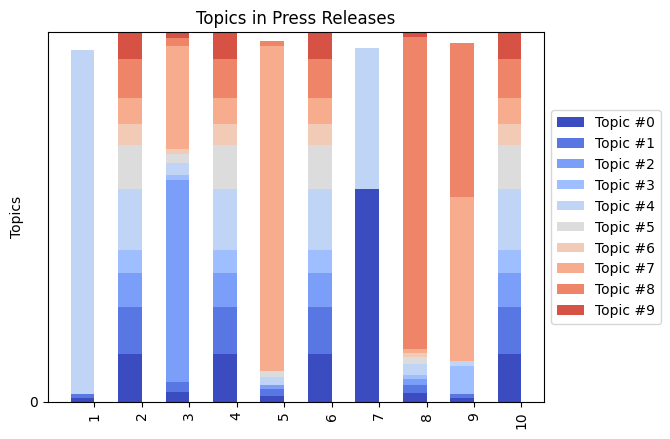

In [127]:
# stacked bar chart
N = 10
ind = np.arange(N)
K = wialda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, wialdaDFVis[:, k], width, color=color)
    else:
        p = plt.bar(ind, wialdaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += wialdaDFVis[:, k]
    plots.append(p)


plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.ylabel('Topics')

plt.title('Topics in Press Releases')
plt.xticks(ind+width/2, wialdaDFVisNames, rotation='vertical')

plt.yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

plt.show()

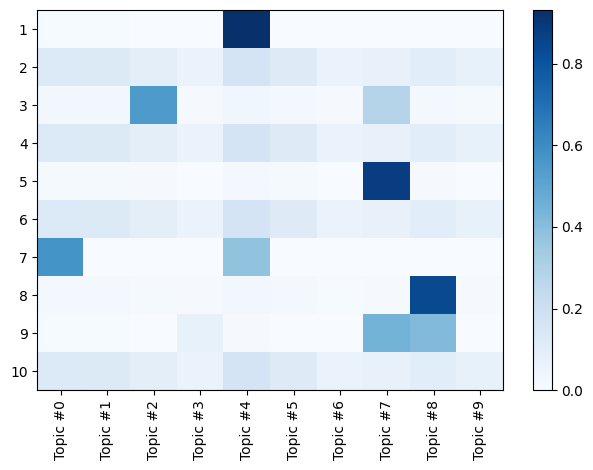

In [128]:
# heat map

plt.pcolor(wialdaDFVis, norm=None, cmap='Blues')
plt.yticks(np.arange(wialdaDFVis.shape[0])+0.5, wialdaDFVisNames);
plt.xticks(np.arange(wialdaDFVis.shape[1])+0.5, topic_labels);

# flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
plt.gca().invert_yaxis()

# rotate the ticks on the x-axis
plt.xticks(rotation=90)

# add a legend
plt.colorbar(cmap='Blues')
plt.tight_layout()  # fixes margins
plt.show()

In [129]:
# top words
wialda.show_topic(3)

[('方向', 0.005922694),
 ('会', 0.004242883),
 ('研究', 0.0040909112),
 ('好', 0.0036708356),
 ('姐妹', 0.0035409045),
 ('写', 0.0033662755),
 ('学校', 0.0032366654),
 ('工作', 0.0032009478),
 ('有没有', 0.0030362075),
 ('专业', 0.0030282822)]

In [130]:
topicsDict = {}
for topicNum in range(wialda.num_topics):
    topicWords = [w for w, p in wialda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pandas.DataFrame(topicsDict)
wordRanksDF

Topic_0 Topic_1 Topic_2 Topic_3 Topic_4 Topic_5     Topic_6 Topic_7 Topic_8  \
0      老师      申请      研究      方向      导师       写           说       I      申请   
1      申请       会       会       会       说       会           a      学校      专业   
2       去       好      女性      研究       会      姐妹           会       a      学校   
3      学校      学校       说       好      老师      专业         The      研究      项目   
4      工作      方向       人      姐妹       写      论文           人      申请      工作   
5      方向       说      学术       写       好       好  University       ’      博士   
6       说       去      方向      学校      论文       看           好   https       人   
7      导师      研究       写      工作      感觉      研究           去       去      美国   
8       好       😭      时间     有没有       去      老师          学校       会       会   
9      国内      真的      分享      专业       看      文献          申请       写      研究   

  Topic_9  
0      研究  
1      申请  
2       去  
3       好  
4      方向  
5       会  
6      姐妹  
7      专业  
8      项目  
9       写

<Figure size 640x480 with 0 Axes>

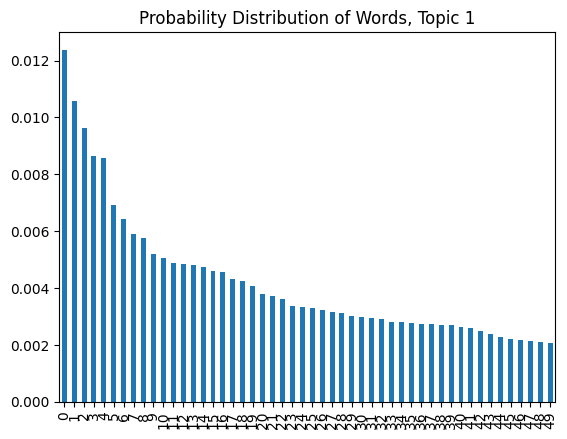

In [131]:
topic1_df = pandas.DataFrame(wialda.show_topic(1, topn=50))
plt.figure()
topic1_df.plot.bar(legend = False)
plt.title('Probability Distribution of Words, Topic 1')
plt.show()

###How does eta value change influence the outcome?
Since eta is a parameter for the prior distribution over word weights in each topic, we should look at the graphs representing the proportions that topic1's top words take.

Seen from the resulting visualization, we can make the conclusion: the higher the eta is, the smaller the overlaps between topics are.

/usr/local/lib/python3.10/dist-packages/gensim/models/ldamodel.py:850: RuntimeWarning: overflow encountered in exp2
  perwordbound, np.exp2(-perwordbound), len(chunk), corpus_words


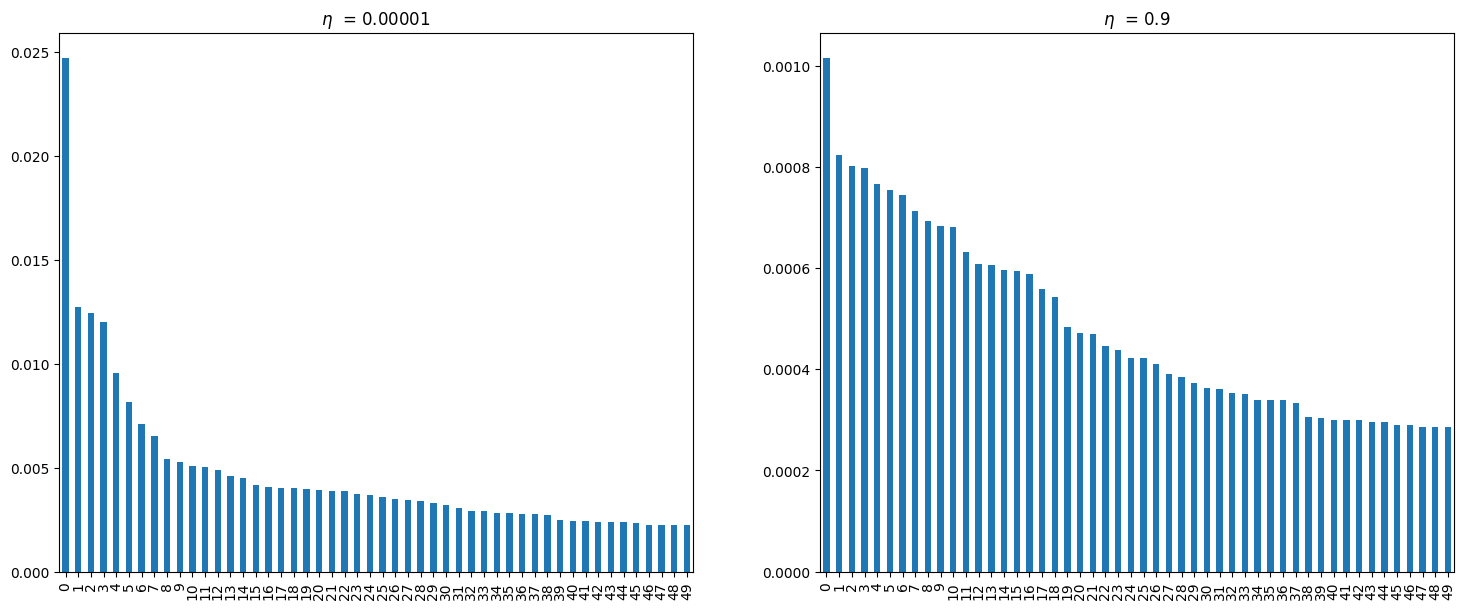

In [132]:

wialda1 = gensim.models.ldamodel.LdaModel(corpus=wia_mm, id2word=dictionary_wia, num_topics=10, eta = 0.00001)
wialda2 = gensim.models.ldamodel.LdaModel(corpus=wia_mm, id2word=dictionary_wia, num_topics=10, eta = 0.9)

topic11_df = pandas.DataFrame(wialda1.show_topic(1, topn=50))
topic21_df = pandas.DataFrame(wialda2.show_topic(1, topn=50))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
topic11_df.plot.bar(legend = False, ax = ax1, title = '$\eta$  = 0.00001')
topic21_df.plot.bar(legend = False, ax = ax2, title = '$\eta$  = 0.9')
plt.show()


###How does alpha influence the topic modeling outcome?
Since alpha is a parameter that controls the prior distribution over topic weights in each document, we should investigate how does the stacked bar chart change in topic distribution as alpha change.

From the following two graphs generated, the rule could be that higher alpha makes the topics more evenly distributed in each document. When the alpha is lower, chances are that one document could be dominated by a main topic significantly.

In [133]:

wialda1 = gensim.models.ldamodel.LdaModel(corpus=wia_mm, id2word=dictionary_wia, num_topics=10, alpha = 0.00001)
wialda2 = gensim.models.ldamodel.LdaModel(corpus=wia_mm, id2word=dictionary_wia, num_topics=10, alpha = 0.9)

ldaDF1 = pandas.DataFrame({
        'name' : wia['Title'],
        'topics' : [wialda1[dictionary.doc2bow(l)] for l in wia['tokenized_text']]
    })
ldaDF2 = pandas.DataFrame({
        'name' : wia['Title'],
        'topics' : [wialda2[dictionary.doc2bow(l)] for l in wia['tokenized_text']]
    })

In [134]:
#Dict to temporally hold the probabilities
topicsProbDict1 = {i : [0] * len(ldaDF1) for i in range(wialda1.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(ldaDF1['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict1[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(senlda.num_topics):
    ldaDF1['topic_{}'.format(topicNum)] = topicsProbDict1[topicNum]

In [135]:
#Dict to temporally hold the probabilities
topicsProbDict2 = {i : [0] * len(ldaDF2) for i in range(wialda2.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(ldaDF2['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict2[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(senlda.num_topics):
    ldaDF2['topic_{}'.format(topicNum)] = topicsProbDict2[topicNum]

In [136]:
ldaDFV1 = ldaDF1[:10][['topic_%d' %x for x in range(10)]]
ldaDFVisN1 = ldaDF1.index[:10]
ldaDFVis1 = ldaDFV1.values
ldaDFVisNames1 = ldaDFVisN1.values
ldaDFV1

topic_0   topic_1   topic_2  topic_3   topic_4   topic_5  topic_6  \
1       0.0  0.000000  0.000000      0.0  0.000000  0.211989      0.0   
2       0.1  0.100000  0.100000      0.1  0.100000  0.100000      0.1   
3       0.0  0.999979  0.000000      0.0  0.000000  0.000000      0.0   
4       0.1  0.100000  0.100000      0.1  0.100000  0.100000      0.1   
5       0.0  0.000000  0.630727      0.0  0.000000  0.000000      0.0   
6       0.1  0.100000  0.100000      0.1  0.100000  0.100000      0.1   
7       0.0  0.000000  0.000000      0.0  0.152908  0.000000      0.0   
8       0.0  0.000000  0.000000      0.0  0.000000  0.999981      0.0   
9       0.0  0.000000  0.000000      0.0  0.654579  0.000000      0.0   
10      0.1  0.100000  0.100000      0.1  0.100000  0.100000      0.1   

     topic_7   topic_8  topic_9  
1   0.307717  0.480289      0.0  
2   0.100000  0.100000      0.1  
3   0.000000  0.000000      0.0  
4   0.100000  0.100000      0.1  
5   0.369261  0.000000      0.0  
6   0.100000  0.100000      0.1  
7   0.710330  0.136757      0.0  
8   0.000000  0.000000      0.0  
9   0.345414  0.000000      0.0  
10  0.100000  0.100000      0.1

In [137]:
ldaDFV2 = ldaDF2[:10][['topic_%d' %x for x in range(10)]]
ldaDFVisN2 = ldaDF2.index[:10]
ldaDFVis2 = ldaDFV2.values
ldaDFVisNames2 = ldaDFVisN2.values
ldaDFV2

topic_0   topic_1   topic_2   topic_3   topic_4   topic_5   topic_6  \
1   0.062579  0.053501  0.046539  0.070276  0.048784  0.388510  0.070284   
2   0.100000  0.100000  0.100000  0.100000  0.100000  0.100000  0.100000   
3   0.193653  0.077156  0.079419  0.109747  0.086374  0.083475  0.078679   
4   0.100000  0.100000  0.100000  0.100000  0.100000  0.100000  0.100000   
5   0.095361  0.082124  0.094314  0.143139  0.074221  0.161221  0.083442   
6   0.100000  0.100000  0.100000  0.100000  0.100000  0.100000  0.100000   
7   0.117124  0.166077  0.048042  0.056338  0.063587  0.068313  0.060168   
8   0.088127  0.093440  0.088056  0.114645  0.120645  0.110979  0.087660   
9   0.073920  0.109113  0.064493  0.131095  0.124085  0.080501  0.079672   
10  0.101437  0.099588  0.099735  0.100360  0.099677  0.099704  0.099767   

     topic_7   topic_8   topic_9  
1   0.160274  0.047431  0.051823  
2   0.100000  0.100000  0.100000  
3   0.096727  0.110065  0.084706  
4   0.100000  0.100000  0.100000  
5   0.113029  0.071522  0.081627  
6   0.100000  0.100000  0.100000  
7   0.099752  0.054590  0.266009  
8   0.115089  0.092292  0.089065  
9   0.064947  0.126627  0.145546  
10  0.099631  0.099896  0.100204

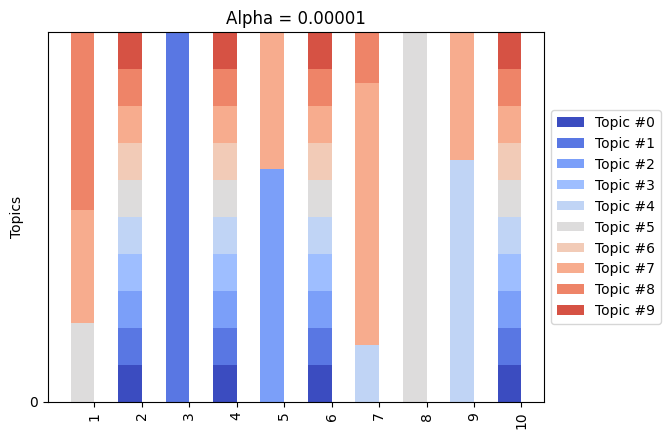

In [138]:
N = 10
ind = np.arange(N)
K = wialda1.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, ldaDFVis1[:, k], width, color=color)
    else:
        p = plt.bar(ind, ldaDFVis1[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += ldaDFVis1[:, k]
    plots.append(p)


plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.ylabel('Topics')

plt.title('Alpha = 0.00001')
plt.xticks(ind+width/2, ldaDFVisNames1, rotation='vertical')

plt.yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

plt.show()

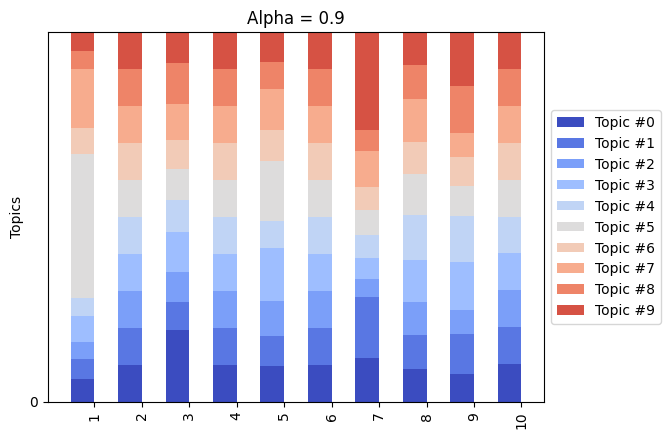

In [139]:
N = 10
ind = np.arange(N)
K = wialda2.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, ldaDFVis2[:, k], width, color=color)
    else:
        p = plt.bar(ind, ldaDFVis2[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += ldaDFVis2[:, k]
    plots.append(p)


plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.ylabel('Topics')

plt.title('Alpha = 0.9')
plt.xticks(ind+width/2, ldaDFVisNames2, rotation='vertical')

plt.yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

plt.show()

## Extending Topic Models within broader research pipelines

Topic models can be the base of more complex analysis. One good example is the paper - Individuals, institutions, and innovation in the debates of the French Revolution (https://www.pnas.org/content/115/18/4607), where they use topic models to find similarities and differences between the topics of different individuals. Let us revisit this idea using the Soap opera database. Who innovates and influences the most within the Soap?

The next few lines of code follows the same process as last weeks notebook. Please visit the old notebook to read descriptions of the code if you have forgotten what it does. `lucem_illud.loadDavies` can be found in [loaders.py](https://github.com/UChicago-Computational-Content-Analysis/lucem_illud/blob/main/lucem_illud/loaders.py).

In [156]:
corpora_address = "/content/drive/MyDrive/SOAP"


In [157]:
soap_texts = lucem_illud.loadDavies(corpora_address, num_files=2000)

text_6-egn.zip
text_7-jss.zip
text_5-rag.zip
text_2-wts.zip
text_9-jtw.zip
text_8-sbo.zip
text_4-jfy.zip
text_3-pem.zip
text_1-teh.zip
text_0-tez.zip


In [159]:
import zipfile
import pandas as pd

In [160]:
zfile = zipfile.ZipFile(corpora_address + "/soap_sources.zip")
source = []

In [161]:
for file in zfile.namelist():
    with zfile.open(file) as f:
        for line in f:
            source.append(line)

In [162]:
soap_dict = {}

In [163]:
for soap in source[3:]:
    try:
        textID, year, show, url = soap.decode("utf-8").split("\t")
    except UnicodeDecodeError:
        continue
    if show.strip() not in soap_dict:
        soap_dict[show.strip()] = []
    if show.strip() in soap_dict:
        try:
            soap_dict[show.strip()].append(soap_texts[textID.strip()])
        except KeyError:
            continue

In [164]:
soap_dict.keys()

dict_keys(['All My Childen', 'As the World Turns', 'Bold and Beautiful', 'Days of Our Lives', 'General Hospital', 'Guiding Light', 'One Life to Live', 'Passions', 'Port Charles', 'Young and Restless'])

In [165]:
soap_df = pd.DataFrame(columns=["Soap Name", "Tokenized Texts"])

In [166]:
i = 0

In [167]:
for soap in soap_dict:
    # since there were multiple lists
    print(soap)
    full_script = []
    for part in soap_dict[soap]:
        full_script = full_script + part
    soap_df.loc[i] = [soap, full_script]
    i += 1

All My Childen
As the World Turns
Bold and Beautiful
Days of Our Lives
General Hospital
Guiding Light
One Life to Live
Passions
Port Charles
Young and Restless


In [168]:
soap_df

Soap Name                                    Tokenized Texts
0      All My Childen  [@!Ryan, Gillian, you, can, come, back, to, me...
1  As the World Turns  [@!Adamski, I, 'm, sorry, ma'am, @!Lily, No, w...
2  Bold and Beautiful  [@!Deacon, I, leave, here, with, Bridget, or, ...
3   Days of Our Lives  [@!Craig, Nancy, why, do, n't, you, get, a, su...
4    General Hospital  [@!Angel, It, 's, possible, to, be, attracted,...
5       Guiding Light  [@!Carmen, Great, day, Great, day, I, ca, n't,...
6    One Life to Live  [@!Hank, Bo, Hey, buddy, @!Bo, Yeah, yeah, @!H...
7            Passions  [@!Pilar, Grace, please, call, Sam, Tell, him,...
8        Port Charles  [@!Ian, You, ok, @!Eve, I, 'm, scared, to, dea...
9  Young and Restless  [@!Judge, Counsel, the, witness, already, invo...

Checking to see which index I should use. In my example it is the last one, so I choose my index as 9. It might be different for you!

In [169]:
dool = soap_df['Tokenized Texts'][9]

In [170]:
' '.join(dool[0:1500])

"@!Judge Counsel the witness already invoked his Fifth Amendment rights @!Larry That had nothing to do with me @!John Who did it have to do with Mr Warton @!Larry Forget it I 'm not answering that @!John Did Matt Clark discuss using a laptop computer with you @!Judge Hold on Do you intend on answering these questions @!Larry I 'm not talking about Matt Clark or drugs or any apartments in Milwaukee and I 'm not talking about the death of some kid All of that stuff is off limits @!Judge I think it 's best if you moved on @!John That 's all Mr Warton @!Raul We can be the four musketeers like before You me Mac Rianna @!Rianna Hey look at the man in street clothes @Mackenzie Have you seen Raul Gutierrez @!Rianna You 're finally going home Are you okay @!Raul I 'm a little nervous actually Hey Mac @!Mackenzie Hey You 're nervous About what @!Olivia Good you 're all @!Olivia Well your friend is going to learn how to inject himself @!Christine That 's the reason why you 're pressing me so hard

In [171]:
characters = {}
for token in dool:
    if token[0] == '@':
        # all characters or actions start with @, so we add that to character
        if token[2:] not in characters:
            characters[token[2:]] = 0
        if token[2:] in characters:
            characters[token[2:]] += 1

In [172]:
import networkx as nx

In [173]:
actor_network = nx.Graph()

In [174]:
for character in characters:
    if characters[character] > 2000:
        actor_network.add_node(character, lines_spoken= characters[character], words=[])

In [175]:
i = 0

In [176]:
all_texts = []

In [177]:
for token in dool:
    i += 1
    if i > len(dool):
        break
    if token[0] == "@":
        if token[2:] in actor_network.nodes():
            j = i
            for token_ in dool[i:]:
                if token_[0] == "@":
                    # if both the characters exist in the graph, add a weight
                    if token_[2:] != token[2:] and token_[2:] in actor_network.nodes():
                        if (token[2:], token_[2:]) not in actor_network.edges():
                            actor_network.add_edge(token[2:], token_[2:], weight=0)
                        if (token[2:], token_[2:]) in actor_network.edges():
                            actor_network.edges[(token[2:], token_[2:])]['weight'] += 1
                    break
                j += 1
            # adding characters sentences
            actor_network.nodes[token[2:]]['words'].append(dool[i:j])
            all_texts.append(lucem_illud.normalizeTokens(dool[i:j]))

/usr/local/lib/python3.10/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


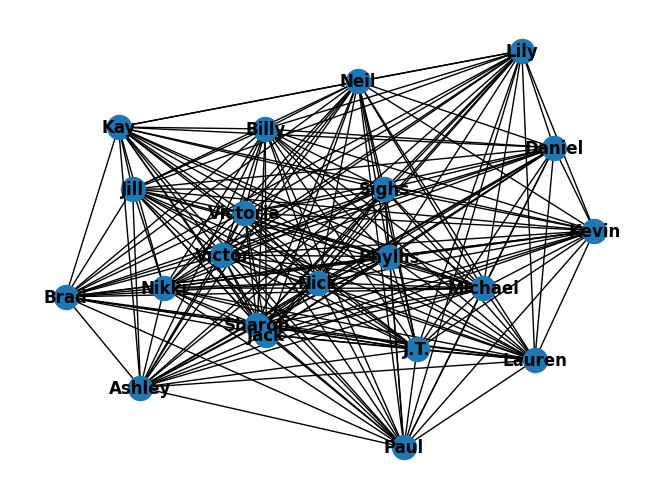

In [178]:
nx.draw(actor_network, with_labels=True, font_weight='bold')

Ok - so we have our graph now. Let us create a topic model with all the texts spoken by the characters, see what's being spoken about, and construct topic distributions for each character. What does our all_texts corpus look like?

In [179]:
all_texts[0:10]

[['tell', 'thank', 'phone', 'company', 'got', 'subpoena', 'moving', 'fast'],
 ['m',
  'waiting',
  'court',
  'dinner',
  'air',
  'm',
  'willing',
  'play',
  'food',
  'critic'],
 ['delicious', 'end', 'lady', 'talent'],
 ['told', 'agenda'],
 ['timing',
  'know',
  'christine',
  'plans',
  'time',
  'probably',
  'talked',
  'staying',
  'room',
  'week',
  'sense',
  'hitting',
  'needs',
  'break'],
 ['finished'],
 ['finished'],
 ['let', 'help', 'dinner', 'dad'],
 ['crazy', 'day', 'told'],
 ['know', 'thinking', 'called', 'caterer', 'ordered', 'cancel']]

In [180]:
dictionary = gensim.corpora.Dictionary(all_texts)

In [181]:
corpus = [dictionary.doc2bow(text) for text in all_texts]

In [182]:
gensim.corpora.MmCorpus.serialize('dool.mm', corpus)
doolcorpus = gensim.corpora.MmCorpus('dool.mm')

In [183]:
doollda = gensim.models.ldamodel.LdaModel(corpus=doolcorpus, id2word=dictionary, num_topics=10, alpha='auto', eta='auto')

In [184]:
doollda.show_topics()

[(0,
  '0.074*"hey" + 0.053*"going" + 0.038*"sharon" + 0.028*"little" + 0.024*"m" + 0.023*"long" + 0.021*"time" + 0.018*"door" + 0.014*"daughter" + 0.014*"guys"'),
 (1,
  '0.153*"okay" + 0.122*"uh" + 0.043*"need" + 0.021*"billy" + 0.021*"huh" + 0.020*"said" + 0.014*"m" + 0.013*"feel" + 0.012*"bad" + 0.012*"cane"'),
 (2,
  '0.154*"know" + 0.037*"way" + 0.023*"help" + 0.018*"nick" + 0.018*"adam" + 0.017*"like" + 0.016*"happy" + 0.015*"whoa" + 0.015*"wanted" + 0.015*"hurt"'),
 (3,
  '0.165*"oh" + 0.085*"m" + 0.053*"thank" + 0.043*"sorry" + 0.028*"god" + 0.026*"baby" + 0.021*"hear" + 0.018*"great" + 0.015*"trying" + 0.015*"find"'),
 (4,
  '0.131*"to" + 0.117*"go" + 0.053*"m" + 0.023*"dad" + 0.022*"mom" + 0.020*"stop" + 0.018*"better" + 0.015*"hell" + 0.013*"katherine" + 0.013*"know"'),
 (5,
  '0.148*"right" + 0.072*"want" + 0.036*"daisy" + 0.034*"sure" + 0.033*"maybe" + 0.029*"m" + 0.024*"phone" + 0.022*"fine" + 0.017*"listen" + 0.016*"thanks"'),
 (6,
  '0.159*"yeah" + 0.054*"mean" + 0.045

Are your topics interpretable/interesting? Sometimes they require a good deal of fine tuning and parameter choosing to get it to work in a nice way. Check out the gensim ldamodel documentation page and see what parameters you can play around with and try the model again!

In [185]:
for actor in actor_network.nodes():
    actor_all_words = []
    for sent in actor_network.nodes[actor]['words']:
        for word in sent:
            actor_all_words += word
    actor_network.nodes[actor]['topic_distribution'] = doollda[dictionary.doc2bow(lucem_illud.normalizeTokens(actor_all_words))]

We now have topic distributions for each character. Let us have a brief look at what the characters are talking about.

In [186]:
for actor in actor_network.nodes():
    print(actor, actor_network.nodes[actor]['topic_distribution'])

Paul [(0, 0.11074524), (1, 0.04968248), (2, 0.083321705), (4, 0.03911528), (5, 0.064244516), (7, 0.33772963), (8, 0.23197107), (9, 0.083185494)]
Michael [(0, 0.11071264), (1, 0.047028814), (2, 0.082751974), (4, 0.04015923), (5, 0.070639156), (7, 0.33476081), (8, 0.23384942), (9, 0.0800955)]
Brad [(0, 0.107994124), (1, 0.049531206), (2, 0.07986146), (4, 0.04073135), (5, 0.061736573), (7, 0.34042054), (8, 0.23528863), (9, 0.08443174)]
Ashley [(0, 0.10995281), (1, 0.053268034), (2, 0.08321301), (4, 0.03881236), (5, 0.058954336), (7, 0.33292574), (8, 0.23653387), (9, 0.086336195)]
Billy [(0, 0.10822361), (1, 0.055321794), (2, 0.085339956), (4, 0.04283168), (5, 0.06118071), (7, 0.3295878), (8, 0.23546128), (9, 0.08204871)]
Phyllis [(0, 0.10977936), (1, 0.05446328), (2, 0.08600309), (4, 0.041078478), (5, 0.05903681), (7, 0.32779923), (8, 0.23552983), (9, 0.08630799)]
Victor [(0, 0.10843019), (1, 0.053363524), (2, 0.08071605), (4, 0.037058346), (5, 0.063348174), (7, 0.33675733), (8, 0.2372363

Quickly eye-balling these distributions suggest that the model itself could be tuned better - all the topics are loaded more or less equally.

In the paper I linked to earlier, they found similarities or differences using the KL divergence - this is a topic we've dealt with before. Let us plot a heatmap with these values.

In [187]:
from gensim.matutils import kullback_leibler

In [188]:
def convert_to_prob(bow):
    ps = []
    for topic_no, topic_prob in bow:
        ps.append(topic_prob)
    return ps

In [189]:
L = []
for actor_1 in actor_network.nodes():
    p = actor_network.nodes[actor_1]['topic_distribution']
    p = convert_to_prob(p)
    l = []
    for actor_2 in actor_network.nodes():
        q = actor_network.nodes[actor_2]['topic_distribution']
        q = convert_to_prob(q)
        l.append(kullback_leibler(p, q))
    L.append(l)
M = np.array(L)

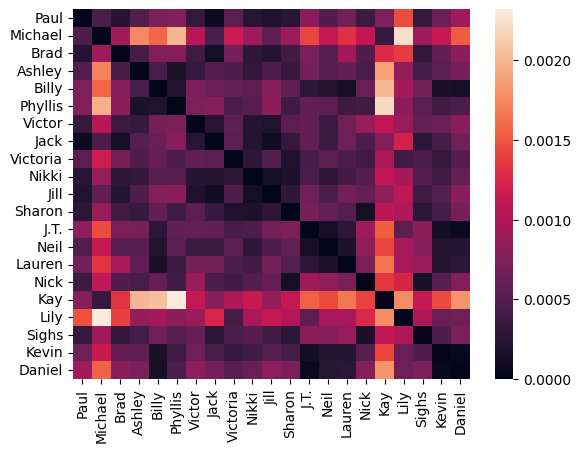

In [190]:
fig = plt.figure()
div = pandas.DataFrame(M, columns = list(actor_network.nodes()), index = list(actor_network.nodes()))
ax = sns.heatmap(div)
plt.show()

This is one example of how we can use topic models to analyse a network - what other data exploration can you come up with?  Maybe see what are the themes surrounding the top topics for each of the actors? You now have the infrastructure to explore the network and the topics. Gensim has a great set of Jupyter Notebooks which illustrate their methods and functions - https://github.com/RaRe-Technologies/gensim/tree/develop/docs/notebooks. The Auto Examples page also has a good variety of examples - https://radimrehurek.com/gensim/auto_examples/.


### Dynamic Topic Modelling

Dynamic Topic Modelling is a time based topic model method introduced by David Blei and John Lafferty. It allows one to see topics evolve over a time annotated corpus. I would recommend first viewing the Dynamic Topic Model tutorial on Gensim (https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/ldaseqmodel.ipynb) to understand what exactly it's about.

(An acknowledgement - Bhargav (the author of most of this class's code) wrote the code for Gensim's Dynamic Topic Models back in 2016 as a Google Summer of Code student, and they're still using it as are thousands of others!)

To demonstrate it on a time based corpus, we will create a corpus from COHA.

In [192]:
corpora_address = "/content/drive/MyDrive/COHA"

In [193]:
coha_texts = lucem_illud.loadDavies(corpora_address, return_raw=True)

text_1920s_gte.zip
text_1940s_bsw.zip
text_1810s_kso.zip
text_1900s_mse.zip
text_1910s_jue.zip
text_2000s_scc.zip
text_1890s_jsq.zip
text_1870s_vuy.zip
text_1860s_psi.zip
text_1840s_nsq.zip
text_1950s_ndz.zip
text_1820s_jsi.zip
text_1930s_bie.zip
text_1980s_bkk.zip
text_1960s_xus.zip
text_1990s_bsj.zip
text_1830s_bsu.zip
text_1850s_jpr.zip
text_1970s_jfy.zip
text_1880s_azz.zip


In [194]:
list(coha_texts.keys())[0:5]

['mag_1920_430825.txt',
 'mag_1920_430826.txt',
 'mag_1920_430827.txt',
 'mag_1920_430828.txt',
 'mag_1920_430829.txt']

We'd have to approach this differently: note that while extracting the corpus we returned the raw texts, and the dictionary keys already contain some useful information: the year published, and the genre. neat! We can now create some corpora, organised by year and by genre.

In [195]:
coha_genres = {}
coha_years = {}

In [196]:
for article in coha_texts:
    genre, year, id_ = article.split("_")
    if genre not in coha_genres:
        coha_genres[genre] = []
    if genre in coha_genres:
        coha_genres[genre].append(coha_texts[article])

    if year not in coha_years:
        coha_years[year] = []
    if year in coha_years:
        coha_years[year].append(coha_texts[article])

In [197]:
coha_genres.keys()

dict_keys(['mag', 'nf', 'fic', 'news'])

In [198]:
coha_years.keys()

dict_keys(['1920', '1921', '1922', '1923', '1924', '1925', '1926', '1927', '1928', '1929', '1940', '1941', '1942', '1943', '1944', '1945', '1946', '1947', '1948', '1949', '1815', '1816', '1817', '1818', '1819', '1810', '1811', '1812', '1813', '1814', '1900', '1901', '1902', '1903', '1904', '1905', '1906', '1907', '1908', '1909', '1910', '1911', '1912', '1913', '1914', '1915', '1916', '1917', '1918', '1919', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '1890', '1891', '1892', '1893', '1894', '1895', '1896', '1897', '1898', '1899', '1870', '1871', '1872', '1873', '1874', '1875', '1876', '1877', '1878', '1879', '1860', '1861', '1862', '1863', '1864', '1865', '1866', '1867', '1868', '1869', '1840', '1841', '1842', '1843', '1844', '1845', '1846', '1847', '1848', '1849', '1950', '1951', '1952', '1953', '1954', '1955', '1956', '1957', '1958', '1959', '1820', '1821', '1822', '1823', '1824', '1825', '1826', '1827', '1828', '1829', '1930', '1931', '1932', '1933

That's neat: we have 4 genres and 200 years. We have to now decide how many time slices we want. Let us see how the corpus is distributed.

If you went through the tutorial, you would notice how we would need to arrange the corpora year wise.
We also have to arrange the number of topics per year.

In [199]:
import collections

In [203]:
years = []
year_lens = []

In [204]:
for year_info in collections.OrderedDict(sorted(coha_years.items())):
    years.append(year_info)
    year_lens.append(len((coha_years[year_info])))

In [205]:
years[0], years[-1]

('1810', '2009')

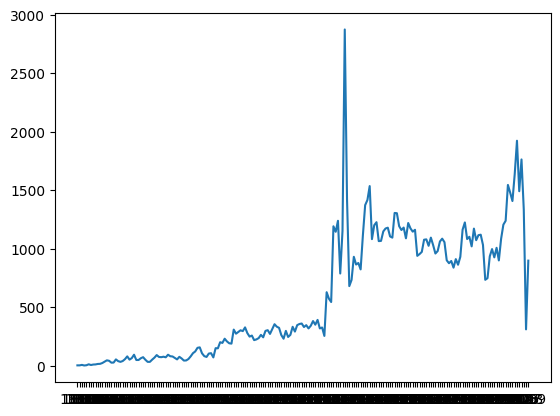

In [206]:
import matplotlib.pyplot as plt
plt.plot(years, year_lens)

The X axis isn't legible, but you can get the point: there are far less articles in the beginning, and then it grows. Maybe in our 5 time slices, we do: 1810-1880, 1881-1913, 1914-1950, 1950-1990, 1990-2009?
I use some historical intuition to use these time periods, you are encouraged to try your different time slices (for e.g, 20 10 year periods, 10 20 year periods, by total number of papers, etc)

In [207]:
all_texts_coha = []
docs_per_timeslice = [0, 0, 0, 0, 0]
i = 0

In [208]:
for year_info in collections.OrderedDict(sorted(coha_years.items())):
    large_files = 0
    for article in coha_years[year_info]:
        try:
            if len(article[2]) < 1500000:
                all_texts_coha.append(lucem_illud.normalizeTokens(article[2].decode("utf-8")))
            if len(article[2]) >= 1500000:
                large_files += 1
        except IndexError:
            continue
    # these numbers are the number of years in the
    if i < 70:
        docs_per_timeslice[0] += len(coha_years[year_info]) - large_files
    if i >= 70 and i < 103:
        docs_per_timeslice[1] += len(coha_years[year_info]) - large_files
    if i >= 103 and i < 140:
        docs_per_timeslice[2] += len(coha_years[year_info]) - large_files
    if i >= 140 and i < 180:
        docs_per_timeslice[3] += len(coha_years[year_info]) - large_files
    if i >= 180:
        docs_per_timeslice[4] += len(coha_years[year_info]) - large_files
    i += 1

/usr/local/lib/python3.10/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


KeyboardInterrupt: 

#### Smaller Corpora

The original size of the corpus is wayyy too big for our laptops. Let us demo this with a smaller size. You are welcome to try different sizes until you get the size you would like.
I am using a 100 documents per time slice for this example.

In [ ]:
def choose_n(corpus, time_slices, nums=100):
    new_corpus = corpus[0:nums]
    for time_slice in time_slices[:-1]:
        new_corpus = new_corpus + corpus[time_slice:time_slice+nums]
    return new_corpus

Now, COHA also has some really large files, full books and the like: we're going to now split up really large files such that each of the documents are only 1000 tokens long. This function will return a split up document and the number of files it has been split into, so we can accordingly adjust the documents per time slice, which is important for Dynamic Topic Modelling to work.

In [ ]:
def split_up(document, doc_size=1000):
    new_docs = [document[i:i + doc_size] for i in range(0, len(document), doc_size)]
    return(new_docs, len(new_docs))

In [ ]:
small_corpus = choose_n(all_texts_coha, docs_per_timeslice, nums=100)

In [ ]:
final_corpus= []

In [ ]:
docs_per_time_slice = [0, 0, 0, 0, 0]

I now use the split method to create my final corpus. Note that I hardcode values for the time slice to figure out the number of documets per time slice. Now I have a representative number of documents in each time slice.

In [ ]:
for i, article in enumerate(small_corpus):
    # identify time slice based on article number
    if i < 100:
        time = 0
    if i > 100 and i <= 200:
        time = 1
    if i > 200 and i <= 300:
        time = 2
    if i > 300 and i <= 400:
        time = 3
    if i > 400 and i <= 500:
        time = 4

    if len(article) > 1000:
        split_docs, no_docs = split_up(article)
        for doc in split_docs:
            final_corpus.append(doc)
        docs_per_time_slice[time] += no_docs
    else:
        final_corpus.append(article)
        docs_per_time_slice[time] += 1
    # just a check if the counts are correctly added
    if np.sum(docs_per_time_slice) != len(final_corpus):
        print(np.sum(docs_per_time_slice), len(final_corpus))

In [ ]:
dictionary = gensim.corpora.Dictionary(final_corpus)

In [ ]:
corpus = [dictionary.doc2bow(text) for text in final_corpus]

In [ ]:
gensim.corpora.MmCorpus.serialize('coha.mm', corpus)
cohacorpus = gensim.corpora.MmCorpus('coha.mm')

In [ ]:
from gensim.models import ldaseqmodel

In [ ]:
# ldaseq = ldaseqmodel.LdaSeqModel(corpus=corpus, id2word=dictionary, time_slice=docs_per_time_slice, num_topics=4)
loaded_model = ldaseqmodel.LdaSeqModel.load("/content/drive/MyDrive/ldaseqmodel")

In [ ]:
ldaseq.print_topics(time=0)[1]

In [ ]:
ldaseq.print_topics(time=4)[1]

What can you see from the analysis? I encourage you to explore the tutorial and see what else you can do with this dataset. In the above model I can see how the topic related to state evolves slowly, with the word president not previously there coming into the topic. I will now save this model and also upload it on GitHub so that you can see how it works. Note that the Dynamic Topic Model is a very time consuming algorithm: you might want to start a run overnight if you intend on using it in your analysis.

In [ ]:
ldaseq.save("ldaseqmodel")

In [ ]:
loaded_model = ldaseqmodel.LdaSeqModel.load("ldaseqmodel")

For future research, you can also consider the Structural Topic Model (STM), which can integrate any covariates (e.g., time, author, document length) into your topic model. Unfortunately there is not yet an implementation of this in Python, but there is a wonderful [R package](https://www.structuraltopicmodel.com/) authored by Molly Roberts, Brandon Stewart, and Dustin Tingley.

Here are plate diagrams of LDA and STM, which may help you visualize the way STM adds covariates to the "left" and "right" of the standard LDA model.

<img src="https://raw.githubusercontent.com/UChicago-Computational-Content-Analysis/Homework-Notebooks/main/week-3/img/lda_stm_plate_diagrams.jpg" alt="https://raw.githubusercontent.com/UChicago-Computational-Content-Analysis/Homework-Notebooks/main/week-3/img/lda_stm_plate_diagrams.jpg" style="width:500px">



## <font color="red">*Exercise 4*</font>

<font color="red">Construct cells immediately below this that use dynamic topic models on datasets relevant to your final project. You can also extend the analysis of the COHA or Soap datasets, if relevant to the comparison of data for your projects. (You could possibly use coha_genres dictionary to conduct analysis on topic evolution for a particular genre? What themes do you see evolving throughout these corpora?)

In [209]:
df = pandas.read_csv("/content/drive/MyDrive/DBCommunity/cleaned_data.csv")

In [210]:
df.head()

Title  \
0  精华\n\n\n                    \n                ...   
1  精华\n\n\n                    \n                ...   
2  精华\n\n\n                    \n                ...   
3  精华\n\n\n                    \n                ...   
4  精华\n\n\n                    \n                ...   

                                                Text   Author  Reply  \
0  由猴面包树组员倡议，我们小组建立官方slack交流群啦！为了营造一个更友好安全的交流氛围，目...  Anon加重音   1115   
1  —————————本帖为问卷调查、招募研究对象的集中贴，姐妹们如有问卷调查需要大家帮忙填写或...  Anon加重音     64   
2  前情(意见征集贴) https://www.douban.com/group/topic/1...  Anon加重音     12   
3  论坛第二期分享会她说PhD：不同的人生路径的文字稿和音频分享来啦。非常感谢小组长们的全力支持...   Sophie      2   
4  09/30/21更新: 管理员实在是没有能力及时追踪所有申请相关的帖子，大家有相关的帖子想要...       丸子      6   

    LastReply PublishTime  Like  Collect  Repost Community_name  \
0  2023-12-21  2020-10-09     2        4       4       Academia   
1  2023-12-01  2020-10-14     1        2       1       Academia   
2  2023-07-04  2020-10-10     4        6       4       Academia   
3  2023-05-03  2020-11-02     1        6       0       Academia   
4  2023-03-25  2020-12-09     2        2       1       Academia   

                                            seg_text  \
0  猴面包树 组员 倡议 小组 建立 官方 slack 交流 群 营造 更 友好 交流 氛围 小...   
1  本帖 问卷调查 招募 研究 对象 贴 姐妹 问卷调查 帮忙 填写 招募 研究 对象 私信 告...   
2  前 情 意见 征集 贴 https www douban group topic 19556...   
3  论坛 第二期 分享 会 说 PhD 人生 路径 文字 稿 音频 分享 非常感谢 小组长 全力...   
4  09 30 21 更新 管理员 实在 能力 追踪 申请 相关 帖子 相关 帖子 想要 推荐 ...   

                                      tokenized_text  Reply_Year  Reply_Month  \
0  ['猴面包树', '组员', '倡议', '小组', '建立', '官方', 'slack'...        2023           12   
1  ['本帖', '问卷调查', '招募', '研究', '对象', '贴', '姐妹', '问...        2023           12   
2  ['前', '情', '意见', '征集', '贴', 'https', 'www', 'd...        2023            7   
3  ['论坛', '第二期', '分享', '会', '说', 'PhD', '人生', '路径...        2023            5   
4  ['09', '30', '21', '更新', '管理员', '实在', '能力', '追...        2023            3   

   Reply_Day  Pub_Year  Pub_Month  Pub_Day  
0         21      2020         10        9  
1          1      2020         10       14  
2          4      2020         10       10  
3          3      2020         11        2  
4         25      2020         12        9

In [211]:
import collections

In [212]:
wia = df[df['Community_name']=="Academia"]
wia.head()

Title  \
0  精华\n\n\n                    \n                ...   
1  精华\n\n\n                    \n                ...   
2  精华\n\n\n                    \n                ...   
3  精华\n\n\n                    \n                ...   
4  精华\n\n\n                    \n                ...   

                                                Text   Author  Reply  \
0  由猴面包树组员倡议，我们小组建立官方slack交流群啦！为了营造一个更友好安全的交流氛围，目...  Anon加重音   1115   
1  —————————本帖为问卷调查、招募研究对象的集中贴，姐妹们如有问卷调查需要大家帮忙填写或...  Anon加重音     64   
2  前情(意见征集贴) https://www.douban.com/group/topic/1...  Anon加重音     12   
3  论坛第二期分享会她说PhD：不同的人生路径的文字稿和音频分享来啦。非常感谢小组长们的全力支持...   Sophie      2   
4  09/30/21更新: 管理员实在是没有能力及时追踪所有申请相关的帖子，大家有相关的帖子想要...       丸子      6   

    LastReply PublishTime  Like  Collect  Repost Community_name  \
0  2023-12-21  2020-10-09     2        4       4       Academia   
1  2023-12-01  2020-10-14     1        2       1       Academia   
2  2023-07-04  2020-10-10     4        6       4       Academia   
3  2023-05-03  2020-11-02     1        6       0       Academia   
4  2023-03-25  2020-12-09     2        2       1       Academia   

                                            seg_text  \
0  猴面包树 组员 倡议 小组 建立 官方 slack 交流 群 营造 更 友好 交流 氛围 小...   
1  本帖 问卷调查 招募 研究 对象 贴 姐妹 问卷调查 帮忙 填写 招募 研究 对象 私信 告...   
2  前 情 意见 征集 贴 https www douban group topic 19556...   
3  论坛 第二期 分享 会 说 PhD 人生 路径 文字 稿 音频 分享 非常感谢 小组长 全力...   
4  09 30 21 更新 管理员 实在 能力 追踪 申请 相关 帖子 相关 帖子 想要 推荐 ...   

                                      tokenized_text  Reply_Year  Reply_Month  \
0  ['猴面包树', '组员', '倡议', '小组', '建立', '官方', 'slack'...        2023           12   
1  ['本帖', '问卷调查', '招募', '研究', '对象', '贴', '姐妹', '问...        2023           12   
2  ['前', '情', '意见', '征集', '贴', 'https', 'www', 'd...        2023            7   
3  ['论坛', '第二期', '分享', '会', '说', 'PhD', '人生', '路径...        2023            5   
4  ['09', '30', '21', '更新', '管理员', '实在', '能力', '追...        2023            3   

   Reply_Day  Pub_Year  Pub_Month  Pub_Day  
0         21      2020         10        9  
1          1      2020         10       14  
2          4      2020         10       10  
3          3      2020         11        2  
4         25      2020         12        9

In [213]:
wia_texts = {}
wia_years = {}

In [216]:
import matplotlib.pyplot as plt

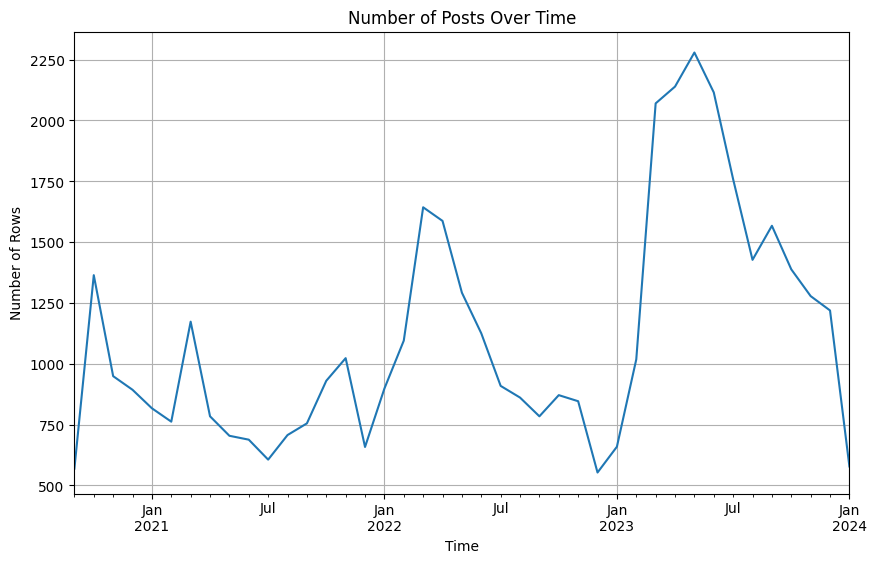

In [218]:
import pandas as pd

# Convert the 'PublishTime' column to datetime format
df['PublishTime'] = pd.to_datetime(df['PublishTime'])

# Group by the desired time period and count the rows
time_series = df.groupby(pd.Grouper(key='PublishTime', freq='M')).size()

# Plotting the time series
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
time_series.plot(kind='line')
plt.title('Number of Posts Over Time')
plt.xlabel('Time')
plt.ylabel('Number of Rows')
plt.grid(True)
plt.show()

In [225]:

df_time = {}  # Create an empty dictionary to store grouped data

# Group the DataFrame by 'PublishTime'
grouped = df.groupby('PublishTime')

# Iterate through the groups and store text data in the dictionary
for time, group_data in grouped:
    df_time[time] = group_data['seg_text'].tolist()

df_time.keys()



dict_keys([Timestamp('2020-09-13 00:00:00'), Timestamp('2020-09-14 00:00:00'), Timestamp('2020-09-15 00:00:00'), Timestamp('2020-09-16 00:00:00'), Timestamp('2020-09-17 00:00:00'), Timestamp('2020-09-18 00:00:00'), Timestamp('2020-09-19 00:00:00'), Timestamp('2020-09-20 00:00:00'), Timestamp('2020-09-21 00:00:00'), Timestamp('2020-09-22 00:00:00'), Timestamp('2020-09-23 00:00:00'), Timestamp('2020-09-24 00:00:00'), Timestamp('2020-09-25 00:00:00'), Timestamp('2020-09-26 00:00:00'), Timestamp('2020-09-27 00:00:00'), Timestamp('2020-09-28 00:00:00'), Timestamp('2020-09-29 00:00:00'), Timestamp('2020-09-30 00:00:00'), Timestamp('2020-10-01 00:00:00'), Timestamp('2020-10-02 00:00:00'), Timestamp('2020-10-03 00:00:00'), Timestamp('2020-10-04 00:00:00'), Timestamp('2020-10-05 00:00:00'), Timestamp('2020-10-06 00:00:00'), Timestamp('2020-10-07 00:00:00'), Timestamp('2020-10-08 00:00:00'), Timestamp('2020-10-09 00:00:00'), Timestamp('2020-10-10 00:00:00'), Timestamp('2020-10-11 00:00:00'), Tim

In [227]:
from gensim.models import ldaseqmodel
loaded_model = ldaseqmodel.LdaSeqModel.load("/content/drive/MyDrive/ldaseqmodel")

In [228]:
df['seg_text']

0        猴面包树 组员 倡议 小组 建立 官方 slack 交流 群 营造 更 友好 交流 氛围 小...
1        本帖 问卷调查 招募 研究 对象 贴 姐妹 问卷调查 帮忙 填写 招募 研究 对象 私信 告...
2        前 情 意见 征集 贴 https www douban group topic 19556...
3        论坛 第二期 分享 会 说 PhD 人生 路径 文字 稿 音频 分享 非常感谢 小组长 全力...
4        09 30 21 更新 管理员 实在 能力 追踪 申请 相关 帖子 相关 帖子 想要 推荐 ...
                               ...                        
45336                                                   解决
45337    楼主 法本 就业 本来 打算 主观题 考试 结束 再 工作 主观题 一延 再延 准信 感觉 ...
45338                      花渣 组 乐子 组 重合 度 活跃性 先发 内容 发布者 删除
45339    过渡 组 新组 名字 很多 姐妹 比较支持 women law 组我试 三四次 创建 成功 ...
45340                                              存自 过渡 组
Name: seg_text, Length: 45341, dtype: object

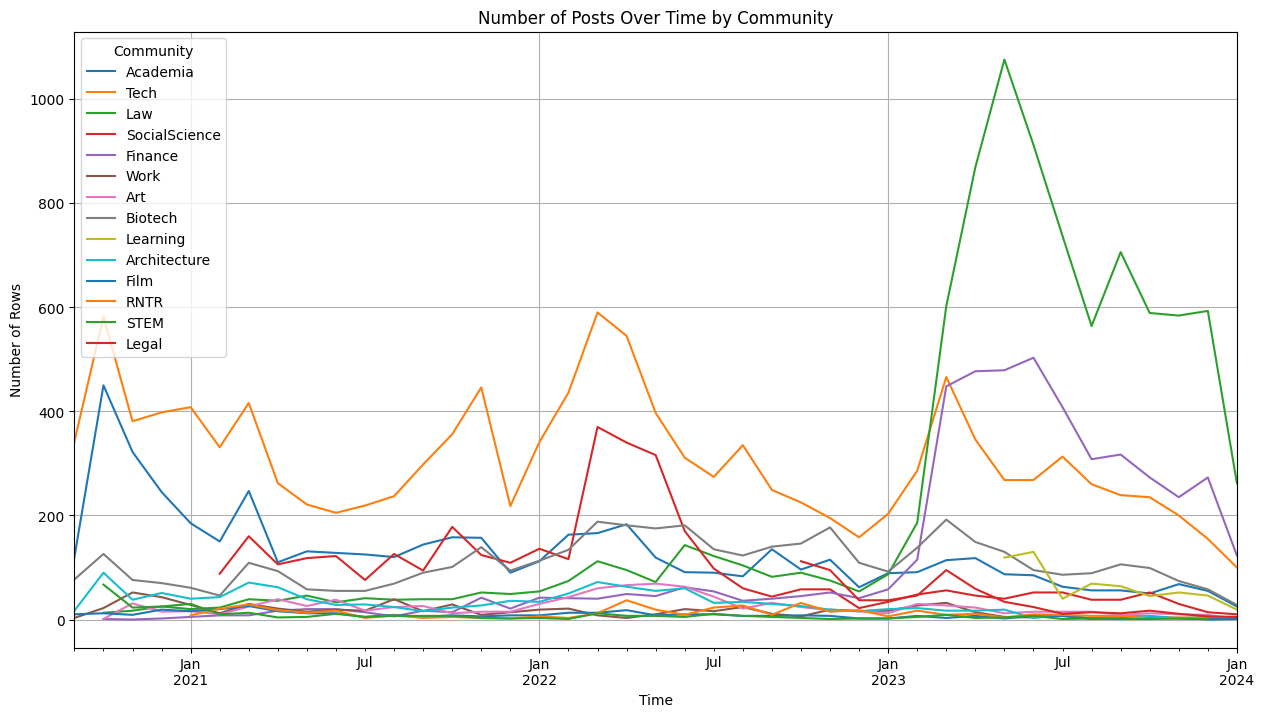

In [229]:
# Set the frequency for time grouping, e.g., 'D' for daily, 'M' for monthly, 'Y' for yearly, etc.
freq = 'M'

# Create a figure and axis for the plot
plt.figure(figsize=(15, 8))

# Iterate over each unique community
for community in df['Community_name'].unique():
    # Filter the DataFrame for the current community
    community_df = df[df['Community_name'] == community]

    # Group by time period and count the rows
    time_series = community_df.groupby(pd.Grouper(key='PublishTime', freq=freq)).size()

    # Plot the time series
    time_series.plot(kind='line', label=community)

# Customize the plot
plt.title('Number of Posts Over Time by Community')
plt.xlabel('Time')
plt.ylabel('Number of Rows')
plt.legend(title='Community')
plt.grid(True)

# Show the plot
plt.show()

From the illustrations above, we can see there's several bursts from 2021 to 2023. Heated discussions among groups are simultaneous.